# Welcome to UTMIST AI2!

[Technical Guide Notebook](https://colab.research.google.com/drive/1qMs336DclBwdn6JBASa5ioDIfvenW8Ha?usp=sharing#scrollTo=-XAOXXMPTiHJ)

[Introductory RL Notebook](https://colab.research.google.com/drive/1JRQFLU5jkMrIJ5cWs3xKEO0e9QKuE0Hi#scrollTo=9UCawVuAI3k0)

[Discord Server](https://discord.com/invite/TTGB62BE9U)

The link to the **LATEST VERSION** of this Colab will always be [here](https://docs.google.com/document/d/1SvlgQSUMLoO3cNx26hzViZOYVPAGa3ECrUSvUyVKvR4/edit?usp=sharing).

Credits:
- General Event Organization: Asad, Efe, Andrew, Matthew, Kaden
- Notebook code: Kaden, Martin, Andrew
- Notebook art/animations: EchoTecho, Andy
- Website code: Zain, Sarva, Adam, Aina
- Workshops: Jingmin, Asad, Tyler, Wai Lim, Napasorn, Sara, San, Alden
- Tournament Server: Ambrose, Doga, Steven
- Technical guide + Conference brochure: Matthew, Caitlin, Lucie

# PATCH: Run this cell first

In [1]:
# Delete assets.zip and /content/assets/
import shutil, gdown, os
import zipfile

if os.path.exists('assets'):
    shutil.rmtree('assets')
if os.path.exists('assets.zip'):
    os.remove('assets.zip')

# Redownload from Drive
data_path = "assets.zip"
print("Downloading assets.zip...")
url = "https://drive.google.com/file/d/1F2MJQ5enUPVtyi3s410PUuv8LiWr8qCz/view?usp=sharing"
gdown.download(url, output=data_path, fuzzy=True)

# Unzip
with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall('.')

# Delete attacks.zip and /content/attacks/
if os.path.exists('attacks'):
    shutil.rmtree('attacks')
if os.path.exists('attacks.zip'):
    os.remove('attacks.zip')

# Redownload from Drive
data_path = "attacks.zip"
print("Downloading attacks.zip...")
url = "https://drive.google.com/file/d/1LAOL8sYCUfsCk3TEA3vvyJCLSl0EdwYB/view?usp=sharing"
gdown.download(url, output=data_path, fuzzy=True)

# Unzip
with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall('.')

Downloading...
From: https://drive.google.com/uc?id=1F2MJQ5enUPVtyi3s410PUuv8LiWr8qCz
To: c:\Users\klamb\OneDrive\Documents\PythonCode\POETS\assets.zip
100%|██████████| 5.01M/5.01M [00:00<00:00, 10.4MB/s]


Downloading...
From: https://drive.google.com/uc?id=1LAOL8sYCUfsCk3TEA3vvyJCLSl0EdwYB
To: c:\Users\klamb\OneDrive\Documents\PythonCode\POETS\attacks.zip
100%|██████████| 9.24k/9.24k [00:00<00:00, 9.24MB/s]


# pip installs

In [2]:
import gc
gc.collect()

15

In [ ]:
# Download the requirements.txt from Google Drive
import gdown, os
data_path = "requirements.txt"
if not os.path.isfile(data_path):
    print("Downloading requirements.txt...")
    url = "https://drive.google.com/file/d/1-4f6NGWtejcn6Q9wUETelVXMFWaA5X0D/view?usp=sharing"
    gdown.download(url, output=data_path, fuzzy=True)

In [4]:
# Malachite and RL requirements
#!pip install torch==2.4.1 gymnasium pygame==2.6.1 pymunk==6.2.1 scikit-image scikit-video sympy==1.5.1 stable_baselines3 sb3-contrib
#!pip install memory_profiler==0.61.0
#!pip install torch==2.4.1 triton==3.0.0 gymnasium pygame==2.6.1 pymunk==6.2.1 scikit-image scikit-video sympy==1.5.1 stable_baselines3 sb3-contrib jupyter gdown opencv-python

#!pip freeze > /content/requirements_v0.txt
# !pip install -r requirements.txt

# Competition Code (DO NOT EDIT)
Please **run this cell** to set your Jupyter Notebook up with all necessary code. Then feel free to move to the `SUBMISSION` sections of this notebook for further instruction.

Note: This cell may take time to run, as it installs the necessary modules then imports them.

## Summary of content:

These cells contain our custom Multi-Agent Reinforcement Learning (MARL) Solution, Malachite, alongside an implementation of a 1v1 platform fighter we've titled Warehouse Brawl. You may look through these cells to get a better sense for the dynamics and functionality of the enviroment, as wel as the various pip installs and modules available for use in your own code.

## Malachite (DO NOT MODIFY UNLESS YOU KNOW WHAT YOU'RE DOING)
The following cells store some code for our custom Multi-Agent Reinforcement Learning (MARL) Solution, called Malachite. It extends some Stable-Baselines 3 functionality to Multi-Agent systems in the context of the AI2 Tournament.

You would only want to modify this if you want to add custom rewards and are dissatisfied with the current flexible rewards system. That's ok! But note that this default environment is what will be used in the tournament, and you will **NOT** have access to any additional data or modifications you may choose to make here.

### Imports

In [5]:
import warnings
from typing import TYPE_CHECKING, Any, Generic, \
 SupportsFloat, TypeVar, Type, Optional, List, Dict, Callable
from enum import Enum, auto
from abc import ABC, abstractmethod
from dataclasses import dataclass, field, MISSING
from collections import defaultdict
from functools import partial
from typing import Tuple, Any

from PIL import Image, ImageSequence
import matplotlib.pyplot as plt

import gdown, os, math, random, shutil, json

import numpy as np
import torch
from torch import nn

import gymnasium
from gymnasium import spaces

import pygame
import pygame.gfxdraw
import pymunk
import pymunk.pygame_util
from pymunk.space_debug_draw_options import SpaceDebugColor
from pymunk.vec2d import Vec2d

import cv2
import skimage.transform as st
import skvideo
import skvideo.io
from IPython.display import Video

### MalachiteEnv Class

In [6]:
ObsType = TypeVar("ObsType")
ActType = TypeVar("ActType")
AgentID = TypeVar("AgentID")

# Reference PettingZoo AECEnv
class MalachiteEnv(ABC, Generic[ObsType, ActType, AgentID]):

    agents: list[AgentID]

    action_spaces: dict[AgentID, gymnasium.spaces.Space]
    observation_spaces: dict[
        AgentID, gymnasium.spaces.Space
    ]

    # Whether each agent has just reached a terminal state
    terminations: dict[AgentID, bool]
    truncations: dict[AgentID, bool]
    rewards: dict[AgentID, float]  # Reward from the last step for each agent
    # Cumulative rewards for each agent
    _cumulative_rewards: dict[AgentID, float]
    infos: dict[
        AgentID, dict[str, Any]
    ]  # Additional information from the last step for each agent

    def __init__(self):
        pass

    @abstractmethod
    def step(self, action: dict[AgentID, ActType]) -> tuple[ObsType,]:
        pass

    @abstractmethod
    def reset(self, seed: int | None = None, options: dict | None = None) -> None:
        pass

    @abstractmethod
    def observe(self, agent: AgentID) -> ObsType | None:
        pass

    @abstractmethod
    def render(self) -> None | np.ndarray | str | list:
        pass

    @abstractmethod
    def close(self) -> None:
        pass

    def show_image(self, image: np.ndarray) -> None:
        plt.imshow(image)
        plt.axis('off')
        plt.show()

    def observation_space(self, agent: AgentID) -> gymnasium.spaces.Space:
        return self.observation_spaces[agent]

    def action_space(self, agent: AgentID) -> gymnasium.spaces.Space:
        return self.action_spaces[agent]


## Environment (DO NOT MODIFY)
Defines the environment for the game. Code adapted from the following sources:
- [Shootout AI](https://github.com/ajwm8103/shootoutai/tree/main)
- [Diffusion Policy](https://diffusion-policy.cs.columbia.edu/)

### Low High Class
Helps structure observation and action spaces.

In [7]:
@dataclass
class ActHelper():
    low: list[Any] = field(default_factory=list)
    high: list[Any] = field(default_factory=list)
    sections: Dict[str, int] = field(default_factory=dict)

    def get_as_np(self) -> Tuple[np.ndarray, np.ndarray]:
        """Return the low and high bounds as NumPy arrays."""
        return np.array(self.low), np.array(self.high)

    def get_as_box(self) -> spaces.Box:
        lowarray, higharray = self.get_as_np()
        return spaces.Box(
            low=lowarray,
            high=higharray,
            shape=lowarray.shape,
            dtype=np.float32
        )

    def zeros(self) -> np.ndarray:
        """
        Returns a zeros vector with the same total dimension as defined by the low vector.
        """
        return np.zeros(len(self.low))

    def add_key(self, name: str):
        """
        Adds a new section with a label to the overall low and high lists.

        Parameters:
            name: A string that identifies the section (e.g., "global_position").
            low_values: A list of low values for this section.
            high_values: A list of high values for this section.

        The method appends the values to the overall lists and records the indices
        where this section is stored. This is later used for observation parsing.
        """
        name = name.lower()
        self.low += [0]
        self.high += [1]
        self.sections[name] = len(self.low)-1

    def press_keys(self, keys: str | List[str], action: Optional[np.ndarray]=None) -> np.ndarray:
        """
        Set a part of the action vector corresponding to the named section.

        Parameters:
            action: The full action vector (np.ndarray) that will be modified.
            partial_action: The values to set for the section.
            name: The section name whose slice is to be replaced.

        Returns:
            The updated action vector.

        Raises:
            ValueError: If the partial action's size does not match the section size.
        """
        if isinstance(keys, str):
            keys = [keys]
        if action is None:
            action = self.zeros()

        for key in keys:
            key = key.lower()
            if key not in self.sections:
                raise KeyError(f"Key '{key}' not found in keys: {self.sections.keys()}")
            action[self.sections[key]] = 1
        return action

    def print_all_sections(self) -> None:
        """
        Prints the names and indices of all sections.
        """
        for name, (start, end) in self.sections.items():
            print(f"{name}: {end - start}")

@dataclass
class ObsHelper():
    low: list[Any] = field(default_factory=list)
    high: list[Any] = field(default_factory=list)
    sections: Dict[str, Tuple[int, int]] = field(default_factory=dict)

    def get_as_np(self) -> Tuple[np.ndarray, np.ndarray]:
        """Return the low and high bounds as NumPy arrays."""
        return np.array(self.low), np.array(self.high)

    def get_as_box(self) -> spaces.Box:
        lowarray, higharray = self.get_as_np()
        return spaces.Box(
            low=lowarray,
            high=higharray,
            shape=lowarray.shape,
            dtype=np.float32
        )

    def zeros(self) -> np.ndarray:
        """
        Returns a zeros vector with the same total dimension as defined by the low vector.
        """
        return np.zeros(len(self.low))

    def add_section(self, low_values: List[Any], high_values: List[Any], name: str) :
        """
        Adds a new section with a label to the overall low and high lists.

        Parameters:
            name: A string that identifies the section (e.g., "global_position").
            low_values: A list of low values for this section.
            high_values: A list of high values for this section.

        The method appends the values to the overall lists and records the indices
        where this section is stored. This is later used for observation parsing.
        """
        name = name.lower()
        start_idx = len(self.low)  # Starting index for this section.
        self.low += low_values
        self.high += high_values
        end_idx = len(self.low)    # Ending index (exclusive) for this section.
        self.sections[name] = (start_idx, end_idx)

    def get_section(self, obs: np.ndarray, name: str) -> np.ndarray:
        start, end = self.sections[name]
        return obs[start:end]

    def print_all_sections(self) -> None:
        """
        Prints the names and indices of all sections.
        """
        for name, (start, end) in self.sections.items():
            print(f"{name}: {end - start}")

### KeyIconPanel

In [8]:
import pygame
import numpy as np

class KeyIconPanel():
    def __init__(self, side: str, edge_percentage: float,
                 width_percentage: float, height_percentage: float,
                 font_size: int = 12):
        """
        :param side: "left" or "right". Determines which edge (far left or far right) is positioned at the given percentage.
        :param edge_percentage: Fraction of the screen width at which the far edge of the panel is placed.
                                For "left", this is the left edge; for "right", this is the right edge.
        :param width_percentage: Panel width as a fraction of screen width.
        :param height_percentage: Panel height as a fraction of screen height.
        :param font_size: Font size for the key labels.
        """
        self.side = side.lower()
        self.edge_percentage = edge_percentage
        self.width_percentage = width_percentage
        self.height_percentage = height_percentage
        self.font_size = font_size
        # Define the keys in order: first 4 (W, A, S, D), then space, then 5 (G, H, J, K, L)
        self.keys = ["W", "A", "S", "D", "Space", "G", "H", "J", "K", "L"]

    def draw_key_icon(self, surface, rect: pygame.Rect, key_label: str, pressed: bool, font):
        """
        Draws a key icon in the specified rect.
          - Draws a rectangle with a 2-pixel border.
          - If pressed, the border and text are red; if not, they are white.
        """
        color = (255, 0, 0) if pressed else (255, 255, 255)
        # Draw the rectangle outline
        pygame.draw.rect(surface, color, rect, 1)
        # Render the key label (centered)
        text_surface = font.render(key_label, True, color)
        text_rect = text_surface.get_rect(center=rect.center)
        surface.blit(text_surface, text_rect)

    def draw(self, camera, input_vector: np.ndarray):
        """
        Draws the panel and key icons onto the given canvas.

        :param canvas: The pygame.Surface on which to draw.
        :param screen_size: Tuple (screen_width, screen_height).
        :param input_vector: np.ndarray of booleans or 0/1 with length 10 in the order [W, A, S, D, Space, G, H, J, K, L].
        """
        canvas = camera.canvas
        screen_width, screen_height = camera.window_width, camera.window_height

        # Calculate panel dimensions
        panel_width = screen_width * self.width_percentage
        panel_height = screen_height * self.height_percentage

        # Determine panel x based on side
        if self.side == "left":
            x = screen_width * self.edge_percentage
        elif self.side == "right":
            x = screen_width * self.edge_percentage - panel_width
        else:
            # Default to centered horizontally if side is invalid.
            x = (screen_width - panel_width) / 2

        # For vertical placement, we'll position the panel at 10% from the top.
        y = screen_height * 0.2
        panel_rect = pygame.Rect(int(x), int(y), int(panel_width), int(panel_height))
        # Draw panel background and border
        pygame.draw.rect(canvas, (50, 50, 50), panel_rect)  # dark gray background
        pygame.draw.rect(canvas, (255, 255, 255), panel_rect, 2)  # white border

        # Create a font for the key icons.
        font = pygame.font.Font(None, self.font_size)
        # Divide the panel vertically into 3 rows.
        row_height = panel_rect.height / 3

        # Row 1: WASD (first 4 keys)
        row1_keys = self.keys[0:4]
        row1_count = len(row1_keys)
        for idx, key in enumerate(row1_keys):
            cell_width = panel_rect.width / row1_count
            cell_rect = pygame.Rect(
                panel_rect.x + idx * cell_width,
                panel_rect.y,
                cell_width,
                row_height
            )
            # Add padding for the icon.
            icon_rect = cell_rect.inflate(-2, -2)
            pressed = input_vector[idx] > 0.5
            self.draw_key_icon(canvas, icon_rect, key, pressed, font)

        # Row 2: Spacebar (only one icon)
        cell_rect = pygame.Rect(
            panel_rect.x,
            panel_rect.y + row_height,
            panel_rect.width,
            row_height
        )
        # Center the spacebar icon in its cell.
        icon_rect = cell_rect.inflate(-2, -2)
        pressed = input_vector[4] > 0.5
        self.draw_key_icon(canvas, icon_rect, "Space", pressed, font)

        # Row 3: GHJKL (last 5 keys)
        row3_keys = self.keys[5:10]
        row3_count = len(row3_keys)
        for idx, key in enumerate(row3_keys):
            cell_width = panel_rect.width / row3_count
            cell_rect = pygame.Rect(
                panel_rect.x + idx * cell_width,
                panel_rect.y + 2 * row_height,
                cell_width,
                row_height
            )
            icon_rect = cell_rect.inflate(-2, -2)
            pressed = input_vector[5 + idx] > 0.5
            self.draw_key_icon(canvas, icon_rect, key, pressed, font)


### UIHandler

In [9]:
class UIHandler():

    def __init__(self, camera):
        # Score images

        SCALE_FACTOR = 0.11
        self.agent_1_score = pygame.image.load('assets/ui/player1ui.png')
        self.agent_1_score = pygame.transform.scale(self.agent_1_score, (int(SCALE_FACTOR * self.agent_1_score.get_width()), int(SCALE_FACTOR * self.agent_1_score.get_height())))
        self.agent_2_score = pygame.image.load('assets/ui/player2ui.png')
        self.agent_2_score = pygame.transform.scale(self.agent_2_score, (int(SCALE_FACTOR * self.agent_2_score.get_width()), int(SCALE_FACTOR * self.agent_2_score.get_height())))

        # Life and death images
        SCALE_FACTOR_2 = SCALE_FACTOR * 0.375
        self.life = pygame.image.load('assets/ui/alicon_alive.png')
        self.life = pygame.transform.scale(self.life, (int(SCALE_FACTOR_2 * self.life.get_width()), int(SCALE_FACTOR_2 * self.life.get_height())))
        self.death = pygame.image.load('assets/ui/alicon_dead.png')
        self.death = pygame.transform.scale(self.death, (int(SCALE_FACTOR_2 * self.death.get_width()), int(SCALE_FACTOR_2 * self.death.get_height())))

        self.score_width, self.score_height = self.agent_1_score.get_size()
        self.agent_1_score_pos = (10, -10)  # Top-left
        self.agent_2_score_pos = (camera.window_width - self.score_width - 10, -10)  # Top-right

    def render(self, camera, env):
        canvas = camera.canvas

        # Score UI positions


        # Draw Score UI

        canvas.blit(self.agent_1_score, self.agent_1_score_pos)
        canvas.blit(self.agent_2_score, self.agent_2_score_pos)

        # Agent lives
        spacing = self.score_width / 3
        for i in range(len(env.players)):
            for j in range(env.players[i].stocks):
                canvas.blit(self.life, (10+j*spacing + i*(camera.window_width - 1.2 * self.score_width), self.score_height - 30))

            # Agent deaths
            for j in range(3 - env.players[i].stocks):
                canvas.blit(self.death, (10 + 2*spacing - j*spacing + i*(camera.window_width - 1.2 * self.score_width), self.score_height - 30))

        self.display_percentages(camera, env)
        self.display_team_name(camera, env)

    def display_team_name(self, camera, env):
        # Define the team name and the bounding rectangle for the text.
        team_name = "Testing this team name"
        # These values can be adjusted to suit your UI layout:
        team_rect_1 = pygame.Rect(self.agent_1_score_pos[0] + 0.2 * self.score_width,
                                self.agent_1_score_pos[1] + 0.75 * self.score_height,
                                0.8 * self.score_width,
                                0.2 * self.score_height)
        team_rect_2 = pygame.Rect(self.agent_2_score_pos[0] + 0 * self.score_width,
                                self.agent_2_score_pos[1] + 0.75 * self.score_height,
                                0.8 * self.score_width,
                                0.2 * self.score_height)
        team_rects = [team_rect_1, team_rect_2]

        # Create a font (same as used for percentages or adjust as needed)
        font = pygame.font.Font(None, 20)

        for i, team_rect in enumerate(team_rects):
            # Render the team name and check if it fits in the rectangle.
            text = env.agent_1_name if i == 0 else env.agent_2_name
            text_surface = font.render(text, True, (255, 255, 255))

            # If the text is too wide, shorten it and add an ellipsis.
            if text_surface.get_width() > team_rect.width:
                # Remove characters until it fits, then add ellipsis.
                while text_surface.get_width() > team_rect.width and len(text) > 0:
                    text = text[:-1]
                    text_surface = font.render(text + "...", True, (255, 255, 255))
                text = text + "..."
                text_surface = font.render(text, True, (255, 255, 255))

            # Draw a red rectangle outline for the team name.
            pygame.draw.rect(camera.canvas, (255, 0, 0), team_rect, 2)

            # Center the text in the rectangle and draw it.
            text_rect = text_surface.get_rect(center=team_rect.center)
            camera.canvas.blit(text_surface, text_rect)

    # Percentages (like SSBU)
    def display_percentages(self, camera, env):
        WHITE = (255, 255, 255)
        ORANGE = (255, 165, 0)
        RED = (255, 0, 0)
        YELLOW = (255, 255, 0)
        DARK_RED = (139, 0, 0)

        # Agent percentage text
        font = pygame.font.Font(None, 35)
        # render text & text colours:
        for i in range(len(env.players)):
            COLOUR = WHITE
            if 50 < env.players[i].damage < 100:
                COLOUR = YELLOW
            elif 100 <= env.players[i].damage < 150:
                COLOUR = ORANGE
            elif 150 <= env.players[i].damage < 200:
                COLOUR = RED
            elif env.players[i].damage >= 200:
                COLOUR = DARK_RED
            percentage = env.players[i].damage * 5 / 7
            text_surface = font.render(f'{percentage:.1f}%', True, COLOUR)
            # text_rect_background = pygame.draw.rect(self.screen, (255,255,255), (220+i*100, 75, 70, 56))
            # text_rect_background_border = pygame.draw.rect(self.screen, (0, 0, 0), (220+i*100, 75, 70, 56), 3)
            text_rect = text_surface.get_rect(center=(self.score_width + i*(camera.window_width - 2 * self.score_width), self.score_height * 1.5/4))
            camera.canvas.blit(text_surface, text_rect)

### Camera

In [10]:
class CameraResolution(Enum):
    LOW = 1
    MEDIUM = 2
    HIGH = 3

class RenderMode(Enum):
    NONE = 0
    RGB_ARRAY = 1
    PYGAME_WINDOW = 2

class Camera():
    screen_width_tiles: float = 29.8
    screen_height_tiles: float = 16.8
    pixels_per_tile: float = 43
    is_rendering: bool = False
    space: pymunk.Space
    pos: list[int] = [0,0]
    zoom: float = 2.0


    def reset(self, env):
        self.space = env.space
        self.objects = env.objects
        self.resolution = env.resolution
        self.resolutions = {
            CameraResolution.LOW: (480, 720),
            CameraResolution.MEDIUM: (720, 1280),
            CameraResolution.HIGH: (1080, 1920)
        }

        self.window_height, self.window_width = self.resolutions[self.resolution]

        # WIDTH HEIGHT in Pixels
        #screen_width_tiles: float = 29.8
        #screen_height_tiles: float = 16.8
        self.pixels_per_tile = self.window_width // self.screen_width_tiles

        #self.window_width = self.screen_width_tiles * self.pixels_per_tile
        #self.window_height = self.screen_height_tiles * self.pixels_per_tile
        self.steps = 0

    def scale_gtp(self) -> float:
        return self.pixels_per_tile * self.zoom

    def _setup_render(self, mode) -> None:
        pygame.init()

        self.ui_handler = UIHandler(self)

        self.key_panel_1 = KeyIconPanel(side="left", edge_percentage=0.22, width_percentage=0.12, height_percentage=0.08)
        self.key_panel_2 = KeyIconPanel(side="right", edge_percentage=0.78, width_percentage=0.12, height_percentage=0.08)

        if mode == RenderMode.PYGAME_WINDOW:
            pygame.display.set_caption("Env")
            self.canvas = pygame.display.set_mode((self.window_width, self.window_height))
            self.clock = pygame.time.Clock()

        # Define font
        self.font50 = pygame.font.Font(None, 50)  # Use the default font with size 50
        self.font = pygame.font.Font(None, 50)

    def process(self) -> None:
        self.steps += 1

    def ptg(self, x, y=None) -> tuple[int, int]:
        if isinstance(x, list) or isinstance(x, tuple) or isinstance(x, np.ndarray):
            x, y = x
        elif isinstance(x, pymunk.Vec2d):
            x, y = x.x, x.y

        scale_cst = self.scale_gtp()
        new_x = -self.screen_width_tiles / 2 + int(x / scale_cst)
        new_y = self.screen_height_tiles / 2 - int(y / scale_cst)
        return new_x, new_y

    def gtp(self, x, y=None) -> tuple[float, float]:
        if isinstance(x, list) or isinstance(x, tuple) or isinstance(x, np.ndarray):
            x, y = x
        elif isinstance(x, pymunk.Vec2d):
            x, y = x.x, x.y

        scale_cst = self.scale_gtp()
        new_x = self.window_width / 2 + (x - self.pos[0]) * scale_cst
        new_y = self.window_height / 2 + (y -self.pos[1]) * scale_cst

        #new_x = self.window_width / 2 + x * self.pixels_per_tile
        #new_y = self.window_height / 2 + y * self.pixels_per_tile
        return new_x, new_y

    def get_frame(self, env, mode=RenderMode.RGB_ARRAY, has_hitboxes=False):
        if not self.is_rendering:
            self._setup_render(mode)
            self.is_rendering = True


        # Expose the canvas for editing
        if mode == RenderMode.RGB_ARRAY:
            self.canvas = pygame.Surface((self.window_width, self.window_height))
        #canvas = pygame.display.set_mode((self.window_width, self.window_height))
        self.canvas.fill((0, 0, 0))

        # Transform PyMunk objects to have (0,0) at center, and such that units are appropriate
        #center_x = self.window_width // 2
        #center_y = self.window_height // 2
        #scale = self.pixels_per_tile
        #transform = pymunk.Transform.identity().translated(center_x, center_y).scaled(scale)

        #center_x = self.screen_width_tiles // 2 - self.pos[0]
        #center_y = self.screen_height_tiles // 2 - self.pos[1]
        center_x = self.window_width // 2
        center_y = self.window_height // 2
        scale = self.pixels_per_tile * self.zoom
        transform = pymunk.Transform.identity().translated(center_x, center_y).scaled(scale).translated(self.pos[0], self.pos[1])
        #transform = pymunk.Transform.identity().scaled(scale).translated(center_x, center_y).scaled(self.zoom)
        draw_options = DrawOptions(self.canvas)
        draw_options.transform = transform

        # Draw PyMunk objects
        #self.space.debug_draw(draw_options)

        #print(self.env.space)
        for obj_name, obj in self.objects.items():
            obj.render(self.canvas, self)

        # Draw UI + Text
        env.handle_ui(self.canvas)

        self.ui_handler.render(self, env)

        if hasattr(env, 'cur_action'):
            self.key_panel_1.draw(self, env.cur_action[0])
            self.key_panel_2.draw(self, env.cur_action[1])

        img = np.transpose(
                np.array(pygame.surfarray.pixels3d(self.canvas)), axes=(1, 0, 2)
            )

        if mode == RenderMode.PYGAME_WINDOW:
            pygame.display.flip()
            pygame.event.pump()
            #pygame.display.update()
            self.clock.tick(50)

        return img

    def close(self) -> None:
        pygame.quit()

### Warehouse Brawl Environment

In [11]:
class Signal():
    def __init__(self, env):
        self._handlers: List[Callable] = []
        self.env = env

    def connect(self, handler: Callable):
        self._handlers.append(handler)

    def emit(self, *args, **kwargs):
        for handler in self._handlers:
            handler(self.env, *args, **kwargs)

In [12]:
class Result(Enum):
    WIN = "win"
    LOSS = "loss"
    DRAW = "draw"

@dataclass
class PlayerStats():
    damage_taken: float
    damage_done: float
    lives_left: int

@dataclass
class MatchStats():
    match_time: float  # Total match time in seconds
    player1: PlayerStats
    player2: PlayerStats
    player1_result: Result

In [13]:
# Define an enumeration for the moves
class MoveType(Enum):
    NONE = auto()         # no move
    NLIGHT = auto()       # grounded light neutral
    DLIGHT = auto()       # grounded light down
    SLIGHT = auto()       # grounded light side
    NSIG = auto()         # grounded heavy neutral
    DSIG = auto()         # grounded heavy down
    SSIG = auto()         # grounded heavy side
    NAIR = auto()         # aerial light neutral
    DAIR = auto()         # aerial light down
    SAIR = auto()         # aerial light side
    RECOVERY = auto()     # aerial heavy neutral and aerial heavy side
    GROUNDPOUND = auto()  # aerial heavy down

    def __int__(self):
        return self.value

    def __float__(self):
        return float(self.value)

# Define a frozen dataclass for the key
@dataclass(frozen=True)
class CompactMoveState():
    grounded: bool
    heavy: bool
    direction_type: int

# Create the dictionary mapping CompactMoveState to a Move
m_state_to_move = {
    CompactMoveState(True, False, 0): MoveType.NLIGHT,      # grounded light neutral
    CompactMoveState(True, False, 1): MoveType.DLIGHT,      # grounded light down
    CompactMoveState(True, False, 2): MoveType.SLIGHT,      # grounded light side
    CompactMoveState(True, True, 0): MoveType.NSIG,          # grounded heavy neutral
    CompactMoveState(True, True, 1): MoveType.DSIG,          # grounded heavy down
    CompactMoveState(True, True, 2): MoveType.SSIG,          # grounded heavy side
    CompactMoveState(False, False, 0): MoveType.NAIR,        # aerial light neutral
    CompactMoveState(False, False, 1): MoveType.DAIR,        # aerial light down
    CompactMoveState(False, False, 2): MoveType.SAIR,        # aerial light side
    CompactMoveState(False, True, 0): MoveType.RECOVERY,     # aerial heavy neutral
    CompactMoveState(False, True, 1): MoveType.GROUNDPOUND,  # aerial heavy down
    CompactMoveState(False, True, 2): MoveType.RECOVERY,     # aerial heavy side
}

class Facing(Enum):
    RIGHT = 1
    LEFT = -1

    def __int__(self):
        return self.value

    @staticmethod
    def flip(facing):
        return Facing.LEFT if facing == Facing.RIGHT else Facing.RIGHT

    @staticmethod
    def from_direction(direction: float) -> "Facing":
        return Facing.RIGHT if direction > 0 else Facing.LEFT

    @staticmethod
    def turn_check(facing, direction) -> bool:
        if facing == Facing.RIGHT and direction < 0:
            return True
        if facing == Facing.LEFT and direction > 0:
            return True
        return False

In [14]:
from pymunk.pygame_util import DrawOptions

"""Coord system
    +------ > x
    |
    |   . (2, 2)
    |
    |      . (3, 3)
    v
    y
"""

class WarehouseBrawl(MalachiteEnv[np.ndarray, np.ndarray, int]):

    BRAWL_TO_UNITS = 1.024 / 320  # Conversion factor

    def __init__(self, mode: RenderMode=RenderMode.RGB_ARRAY, resolution: CameraResolution=CameraResolution.LOW, train_mode: bool = False):
        super(WarehouseBrawl, self).__init__()

        self.stage_width_tiles: float = 29.8
        self.stage_height_tiles: float = 16.8

        self.mode = mode
        self.resolution = resolution
        self.train_mode = train_mode

        self.agents = [0, 1] # Agent 0, agent 1
        self.logger = ['', '']

        # Params
        self.fps = 30
        self.dt = 1 / self.fps
        self.max_timesteps = self.fps * 90

        self.agent_1_name = 'Team 1'
        self.agent_2_name = 'Team 2'

        # Signals
        self.knockout_signal = Signal(self)
        self.win_signal = Signal(self)
        self.hit_during_stun = Signal(self)

        # Observation Space
        self.observation_space = self.get_observation_space()

        self.camera = Camera()

        # Action Space
        # WASD
        self.action_space = self.get_action_space()
        # spaces.Box(low=np.array([0] * 4), high=np.array([1] * 4), shape=(4,), dtype=np.float32)

        self.action_spaces, self.observation_spaces = {}, {}
        for agent_id in self.agents:
            self.action_spaces[agent_id] = self.action_space
            self.observation_spaces[agent_id] = self.observation_space

        self.load_attacks()

        self.reset()

    def get_observation_space(self):
        # lowarray = np.array(
        #     [0, -self.screen_width_tiles/2, -self.screen_width_tiles/2, 0, 0, 0, 0, 0] +
        #     [0 for _ in range(len(Player.states))] +
        #     [0] +
        #     [(0, -self.screen_width_tiles, -self.screen_width_tiles, 0, 0)[i%5] for i in range(self.max_ammo*5)] +
        #     [0, -self.screen_width_tiles/2, -self.screen_width_tiles/2, 0, -self.screen_width_tiles, -self.screen_width_tiles, -self.screen_width_tiles, -self.screen_width_tiles,
        #     0, 0, 0, 0] +
        #     [0 for _ in range(len(Player.states))] +
        #     [(0, -self.screen_width_tiles, -self.screen_width_tiles, 0, 0)[i%5] for i in range(self.max_ammo*5)] +
        #     [0]
        # )
        # higharray = np.array(
        #     [1, self.screen_width_tiles/2, self.screen_width_tiles/2, self.screen_width_tiles/2, 2 * math.pi, 10, 20, 3] +
        #     [1 for _ in range(len(Player.states))] +
        #     [2*math.pi] +
        #     [(1, self.screen_width_tiles, self.screen_width_tiles, 2*math.pi, 2*math.pi)[i%5] for i in range(self.max_ammo*5)] +
        #     [1, self.screen_width_tiles/2, self.screen_width_tiles/2, self.screen_width_tiles/2, self.screen_width_tiles, self.screen_width_tiles, self.screen_width_tiles, self.screen_width_tiles,
        #     2 * math.pi, 2 * math.pi, 20, 3] +
        #     [1 for _ in range(len(Player.states))] +
        #     [(1, self.screen_width_tiles, self.screen_width_tiles, 2*math.pi, 2*math.pi)[i%5] for i in range(self.max_ammo*5)] +
        #     [self.time_limit]
        # )

        obs_helper = ObsHelper()
        self.add_player_obs(obs_helper, 'player')
        self.add_player_obs(obs_helper, 'opponent')

        print('Obs space', obs_helper.low, obs_helper.high)

        self.obs_helper = obs_helper

        return self.obs_helper.get_as_box()

    def add_player_obs(self, obs_helper, name: str='player') -> None:
        # Note: Some low and high bounds are off here. To ensure everyone's code
        # still works, we are not modifying them, but will elaborate in comments.
        # Pos: Unnormalized, goes from [-18, -7], [18, 7], in game units
        obs_helper.add_section([-1, -1], [1, 1], f"{name}_pos")
        # Vel: Unnormalized, goes from [-10, -10], [10, 10] in game units
        obs_helper.add_section([-1, -1], [1, 1], f"{name}_vel")
        obs_helper.add_section([0], [1], f"{name}_facing")
        obs_helper.add_section([0], [1], f"{name}_grounded")
        obs_helper.add_section([0], [1], f"{name}_aerial")
        obs_helper.add_section([0], [2], f"{name}_jumps_left")
        obs_helper.add_section([0], [12], f"{name}_state")
        obs_helper.add_section([0], [1], f"{name}_recoveries_left")
        # Dodge timer: Unnormalized, goes from [0], [82] in frames.
        # Represents the time remaining until can dodge again
        obs_helper.add_section([0], [1], f"{name}_dodge_timer")
        # Stun frames: Unnormalized, goes from [0], [80] in frames
        # Represents the time remaining until the player transitions
        # out of StunState.
        obs_helper.add_section([0], [1], f"{name}_stun_frames")
        obs_helper.add_section([0], [1], f"{name}_damage")
        obs_helper.add_section([0], [3], f"{name}_stocks")
        obs_helper.add_section([0], [11], f"{name}_move_type")

    def get_action_space(self):
        act_helper = ActHelper()
        act_helper.add_key("w") # W (Aim up)
        act_helper.add_key("a") # A (Left)
        act_helper.add_key("s") # S (Aim down/fastfall)
        act_helper.add_key("d") # D (Right)
        act_helper.add_key("space") # Space (Jump)
        act_helper.add_key("h") # H (Pickup/Throw)
        act_helper.add_key("l") # L (Dash/Dodge)
        act_helper.add_key("j") # J (Light Attack)
        act_helper.add_key("k") # K (Heavy Attack)
        act_helper.add_key("g") # G (Taunt)

        print('Action space', act_helper.low, act_helper.high)

        self.act_helper = act_helper

        return self.act_helper.get_as_box()

    def square_floor_collision(arbiter, space, data):
        """
        Collision handler callback that is called when a square collides with the platform.
        It sets the square's collision flag so that is_on_floor() returns True.
        """
        shape_a, shape_b = arbiter.shapes
        # Check both shapes; one of them should be a square.
        if hasattr(shape_a, "owner") and isinstance(shape_a.owner, Player):
            shape_a.owner.collided_this_step = True
        if hasattr(shape_b, "owner") and isinstance(shape_b.owner, Player):
            shape_b.owner.collided_this_step = True
        return True

    def get_stats(self, agent_id: int) -> PlayerStats:
        player = self.players[agent_id]
        return PlayerStats(
            damage_taken=player.damage_taken_total,
            damage_done=player.damage_done,
            lives_left=player.stocks)

    def load_attacks(self):
        # load all from /content/attacks
        self.attacks = {}

        self.keys = {
            'Unarmed NLight': MoveType.NLIGHT,
            'Unarmed DLight': MoveType.DLIGHT,
            'Unarmed SLight': MoveType.SLIGHT,
            'Unarmed NSig':   MoveType.NSIG,
            'Unarmed DSig':   MoveType.DSIG,
            'Unarmed SSig':   MoveType.SSIG,
            'Unarmed NAir':   MoveType.NAIR,
            'Unarmed DAir':   MoveType.DAIR,
            'Unarmed SAir':   MoveType.SAIR,
            'Unarmed Recovery': MoveType.RECOVERY,
            'Unarmed Groundpound': MoveType.GROUNDPOUND,
        }

        for file in sorted(os.listdir('attacks')):
            name = file.split('.')[0]
            if name not in self.keys.keys(): continue
            with open(os.path.join('attacks', file)) as f:
                move_data = json.load(f)

            self.attacks[self.keys[name]] = move_data


    def step(self, action: dict[int, np.ndarray]):
        # Create new rewards dict
        self.cur_action = action
        self.rewards = {agent: 0 for agent in self.agents}
        self.terminated = False
        self.logger = ['', '']

        self.camera.process()

        # Process all other steps
        for obj_name, obj in self.objects.items():
            # If player
            if isinstance(obj, Player):
                continue
            else:
                obj.process()
        # Pre-process player step
        for agent in self.agents:
            player = self.players[agent]
            player.pre_process()

        # Process player step
        for agent in self.agents:
            player = self.players[agent]
            player.process(action[agent])
            if player.stocks <= 0:
                self.terminated = True
                self.win_signal.emit(agent='player' if agent == 1 else 'opponent')


        # Process physics info
        for obj_name, obj in self.objects.items():
            obj.physics_process(self.dt)

        # PyMunk step
        self.space.step(self.dt)
        self.steps += 1

        truncated = self.steps >= self.max_timesteps

        # Collect observations
        observations = {agent: self.observe(agent) for agent in self.agents}

        return observations, self.rewards, self.terminated, truncated, {}

    def add_reward(self, agent: int, reward: float) -> None:
        # Not really in use
        self.rewards[agent] += reward

    def reset(self, seed=None) -> Tuple[dict[int, np.ndarray], dict[str, Any]]:
        self.seed = seed




        self.space = pymunk.Space()
        self.dt = 1 / 30.0
        self.space.gravity = 0, 17.808

        self.steps = 0

        # Other params
        self.rewards = {agent: 0 for agent in self.agents}

        # Game Objects
        self.objects: dict[str, GameObject] = {}

        self.players: list[Player] = []
        self.camera.reset(self)
        self._setup()

        return {agent: self.observe(agent) for agent in self.agents}, {}

    def observe(self, agent: int) -> np.ndarray:
        #  lh = LowHigh()
        # lh += [-1, -1], [1, 1] # 2d vector to goal
        # lh += [-1, -1], [1, 1] # 2d vector of global position
        # lh += [-1, -1], [1, 1] # 2d vector of global velocity

        obs = []
        obs += self.players[agent].get_obs()
        obs += self.players[1-agent].get_obs()
        #obs += self.players[agent].body.position.x, self.players[agent].body.position.y
        #obs += self.players[agent].body.position.x, self.players[agent].body.position.y
        #obs += self.players[agent].body.velocity.x, self.players[agent].body.velocity.y

        return np.array(obs)

    def render(self) -> None | np.ndarray | str | list:
        return self.camera.get_frame(self)

    def handle_ui(self, canvas: pygame.Surface) -> None:
        # Define UI
        # player_stat = f"P1: {self.players[0].stocks}, P2: {self.players[1].stocks}"
        # text_surface = self.camera.font.render(player_stat, True, (255, 255, 255))  # White text
        # text_rect = text_surface.get_rect(center=(self.camera.window_width // 2, 50))  # Center the text
        # canvas.blit(text_surface, text_rect)

        # # Damage
        # small_font = pygame.font.Font(None, 20)
        # text_surface = small_font.render(f"{self.players[0].damage}%, {self.players[1].damage}%", True, (255, 255, 255))  # White text
        # text_rect = text_surface.get_rect(center=(self.camera.window_width // 2, 70))  # Center the text
        # canvas.blit(text_surface, text_rect)

        # Smaller text
        small_font = pygame.font.Font(None, 30)
        text_surface = small_font.render(f"Time: {self.steps}", True, (255, 255, 255))  # White text
        text_rect = text_surface.get_rect(center=(self.camera.window_width // 2, 30))  # Center the text
        canvas.blit(text_surface, text_rect)

        # Smaller text
        small_font = pygame.font.Font(None, 20)
        text_surface = small_font.render(f"P1: {self.logger[0]['transition']}, P2: {self.logger[1]['transition']}", True, (255, 255, 255))  # White text
        text_rect = text_surface.get_rect(center=(self.camera.window_width // 2, 50))  # Center the text
        canvas.blit(text_surface, text_rect)

        # Smaller text
        small_font = pygame.font.Font(None, 20)
        text_surface = small_font.render(f"P1: {self.logger[0].get('move_type', '')}, P2: {self.logger[1].get('move_type', '')}", True, (255, 255, 255))  # White text
        text_rect = text_surface.get_rect(center=(self.camera.window_width // 2, 70))  # Center the text
        canvas.blit(text_surface, text_rect)

        # Smaller text
        text_surface = small_font.render(f"P1 Total Reward: {self.logger[0].get('total_reward', '')}, Reward {self.logger[0].get('reward', '')}", True, (255, 255, 255))  # White text
        text_rect = text_surface.get_rect(center=(0, self.camera.window_height - 40))  # Center the text
        # make it left
        text_rect.left = 0
        canvas.blit(text_surface, text_rect)

        text_surface = small_font.render(f"P2 Total Reward: {self.logger[1].get('total_reward', '')}, Reward {self.logger[1].get('reward', '')}", True, (255, 255, 255))  # White text
        text_rect = text_surface.get_rect(center=(0, self.camera.window_height - 20))  # Center the text
        text_rect.left = 0
        canvas.blit(text_surface, text_rect)



    def observation_space(self, agent: AgentID) -> gymnasium.spaces.Space:
        return self.observation_spaces[agent]

    def action_space(self, agent: AgentID) -> gymnasium.spaces.Space:
        return self.action_spaces[agent]

    def close(self) -> None:
        self.camera.close()

    def _setup(self):
        # Collsion fix
        handler = self.space.add_collision_handler(3, 4)  # (Player1 collision_type, Player2 collision_type)
        handler.begin = lambda *args, **kwargs: False

        # Environment
        ground = Ground(self.space, 0, 2.03, 10.67)
        self.objects['ground'] = ground

        # Players
        # randomize start pos, binary
        p1_right = bool(random.getrandbits(1))
        p1_start_pos = [5, 0] if p1_right else [-5, 0]
        p2_start_pos = [-5, 0] if p1_right else [5, 0]

        # Uncomment this if you'd like. It makes train_mode RANDOMIZE the
        # position of both players, so that they get used to many
        # different positions in the map!

        if self.train_mode:
            p1_start_pos = [random.uniform(-5, 5), 0]
            p2_start_pos = [random.uniform(-5, 5), 0]
        else:
            p1_start_pos = [5, 0] if p1_right else [-5, 0]
            p2_start_pos = [-5, 0] if p1_right else [5, 0]

        p1 = Player(self, 0, start_position=p1_start_pos, color=[0, 0, 255, 255])
        p2 = Player(self, 1, start_position=p2_start_pos, color=[0, 255, 0, 255])

        self.objects['player'] = p1
        self.objects['opponent'] = p2

        self.players += [p1, p2]

### GameObject

In [15]:
class GameObject(ABC):

    def render(self, canvas: pygame.Surface, camera: Camera) -> None:
        pass

    def process(self) -> None:
        pass

    def physics_process(self, dt: float) -> None:
        pass

    @staticmethod
    def draw_image(canvas, img, pos, desired_width, camera, flipped: bool = False):
        """
        Draws an image onto the canvas while correctly handling scaling and positioning.

        Parameters:
            canvas (pygame.Surface): The surface to draw onto.
            img (pygame.Surface): The image to draw.
            pos (tuple): The (x, y) position in game coordinates (center of the desired drawing).
            desired_width (float): The width in game units.
            camera (Camera): The camera object, which has a gtp() method for coordinate conversion.
        """
        # Convert game coordinates to screen coordinates
        screen_pos = camera.gtp(pos)

        # Compute the new width in screen units
        screen_width = int(desired_width * camera.scale_gtp())

        # Maintain aspect ratio when scaling
        aspect_ratio = img.get_height() / img.get_width()
        screen_height = int(screen_width * aspect_ratio)

        # Scale the image to the new size
        scaled_img = pygame.transform.scale(img, (screen_width, screen_height))

        if flipped:
            scaled_img = pygame.transform.flip(scaled_img, True, False)

        # Compute the top-left corner for blitting (since screen_pos is the center)
        top_left = (screen_pos[0] - screen_width // 2, screen_pos[1] - screen_height // 2)

        # Blit the scaled image onto the canvas
        canvas.blit(scaled_img, top_left)


### Other GameObjects

In [16]:
class Ground(GameObject):
    def __init__(self, space, x, y, width_ground, color=(150, 150, 150, 255)):
        self.body = pymunk.Body(x, y, body_type=pymunk.Body.STATIC)
        self.shape = pymunk.Poly.create_box(self.body, (width_ground, 0.1))
        self.shape.collision_type = 2 # Ground
        self.shape.owner = self
        self.shape.body.position = (x, y)
        self.shape.friction = 0.7
        self.shape.color = color

        self.width_ground = width_ground

        space.add(self.shape, self.body)
        self.loaded = False

    def load_assets(self):
        if self.loaded: return
        self.loaded = True
        self.bg_img = pygame.image.load('assets/map/bg.jpg')
        self.stage_img = pygame.image.load('assets/map/stage.png')

    def render(self, canvas, camera) -> None:
        self.load_assets()

        #self.draw_image(canvas, self.bg_img, (0, 0), 29.8, camera)
        self.draw_image(canvas, self.stage_img, (0, 0.8), self.width_ground * 3.2, camera)

### Player

#### PlayerInputInfo

In [17]:
@dataclass
class KeyStatus():
    just_pressed: bool = False
    held: bool = False
    just_released: bool = False

class PlayerInputHandler():
    def __init__(self):
        # Define the key order corresponding to the action vector:
        # Index 0: W, 1: A, 2: S, 3: D, 4: space
        self.key_names = ["W", "A", "S", "D", "space", 'h', 'l', 'j', 'k', 'g']
        # Previous frame key state (all start as not pressed).
        self.prev_state = {key: False for key in self.key_names}
        # The current status for each key.
        self.key_status = {key: KeyStatus() for key in self.key_names}
        # Raw axes computed from key states.
        self.raw_vertical = 0.0   # +1 if W is held, -1 if S is held.
        self.raw_horizontal = 0.0 # +1 if D is held, -1 if A is held.

    def update(self, action: np.ndarray):
        """
        Given an action vector (floats representing 0 or 1),
        update the internal state for each key, including:
          - whether it was just pressed
          - whether it is held
          - whether it was just released
        Also computes the raw input axes for WS and AD.

        Parameters:
            action (np.ndarray): 5-element vector representing the current key states.
        """

        # Update each key's status.
        for i, key in enumerate(self.key_names):
            # Treat a value > 0.5 as pressed.
            current = action[i] > 0.5
            previous = self.prev_state[key]
            self.key_status[key].just_pressed = (not previous and current)
            self.key_status[key].just_released = (previous and not current)
            self.key_status[key].held = current
            # Save the current state for the next update.
            self.prev_state[key] = current

        # Compute the raw axes:
        # Vertical axis: W (+1) and S (-1)
        self.raw_vertical = (1.0 if self.key_status["W"].held else 0.0) + (-1.0 if self.key_status["S"].held else 0.0)
        # Horizontal axis: D (+1) and A (-1)
        self.raw_horizontal = (1.0 if self.key_status["D"].held else 0.0) + (-1.0 if self.key_status["A"].held else 0.0)

    def __repr__(self):
        # For debugging: provide a summary of the key statuses and axes.
        statuses = ", ".join(
            f"{key}: (just_pressed={self.key_status[key].just_pressed}, held={self.key_status[key].held}, just_released={self.key_status[key].just_released})"
            for key in self.key_names
        )
        return (f"PlayerInputHandler({statuses}, "
                f"raw_horizontal={self.raw_horizontal}, raw_vertical={self.raw_vertical})")

#### PlayerObjectState Abstract Base Class

In [18]:
class PlayerObjectState(ABC):
    def __init__(self, player: "Player"):
        self.p: "Player" = player
        self.invincible_timer = 0
        self.dodge_cooldown = 0
        self.stun_time_stored = 0

    def enter(self) -> None:
        pass

    def stunned(self, stun_time: int=0):
        self.stun_time_stored = stun_time

    def vulnerable(self) -> bool:
        return True

    def is_grounded(self) -> bool:
        return False

    def is_aerial(self) -> bool:
        return False

    def physics_process(self, dt: float) -> "PlayerObjectState":
        # Killbox
        sides = abs(self.p.body.position.x) > self.p.env.stage_width_tiles // 2
        tops = abs(self.p.body.position.y) > self.p.env.stage_height_tiles // 2
        if sides or tops:
            return self.p.states['KO']

        #self != self.p.states['stun'] and
        if self.stun_time_stored > 0:
            if self == self.p.states['stun']:
                self.p.env.hit_during_stun.emit(agent='player' if self.p.agent_id == 0 else 'opponent')
            stun_state = self.p.states['stun']
            stun_state.set_stun(self.stun_time_stored)
            self.stun_time_stored = 0
            if hasattr(self, 'jumps_left'):
                stun_state.jumps_left = self.jumps_left
            return stun_state

        # Tick timers
        self.invincible_timer = max(0, self.invincible_timer-1)
        self.dodge_cooldown = max(0, self.dodge_cooldown-1)

        return None

    def exit(self) -> None:
        pass

    def animate_player(self, camera) -> None:
        self.p.attack_sprite.play(None)

    def reset(self, old) -> "PlayerObjectState":
        self.p = old.p
        self.stun_time_stored = 0
        self.invincible_timer = old.invincible_timer
        self.dodge_cooldown = old.dodge_cooldown

        return self

#### Basic States

In [19]:
class GroundState(PlayerObjectState):
    def can_control(self):
        return True

    def is_grounded(self) -> bool:
        return True

    def reset(self, old) -> None:
        super().reset(old)
        if hasattr(old, 'dash_timer'):
            self.dash_timer = old.dash_timer
        else:
            self.dash_timer = 0

    @staticmethod
    def get_ground_state(p: "Player") -> PlayerObjectState:
        if abs(p.input.raw_horizontal) > 1e-2:
            return p.states['walking']
        else:
            return p.states['standing']

    def physics_process(self, dt: float) -> PlayerObjectState:
        new_state = super().physics_process(dt)
        if new_state is not None: return new_state

        if not self.can_control(): return None

        # Handle jump
        direction = self.p.input.raw_horizontal
        near_still = abs(direction) < 1e-2
        if self.p.input.key_status["space"].just_pressed and self.p.is_on_floor():
            self.p.body.velocity = pymunk.Vec2d(self.p.body.velocity.x, -self.p.jump_speed)
            self.p.facing = Facing.from_direction(direction)
            in_air = self.p.states['in_air']
            in_air.refresh()
            return in_air

        if not self.p.is_on_floor():
            in_air = self.p.states['in_air']
            in_air.refresh()
            return in_air

        # Handle dodge
        if near_still and self.p.input.key_status['l'].just_pressed and self.dodge_cooldown <= 0:
            self.dodge_cooldown = self.p.grounded_dodge_cooldown
            dodge_state = self.p.states['dodge']
            dodge_state.set_is_grounded(True)
            return dodge_state

        # Check for attack
        move_type = self.p.get_move()
        if move_type != MoveType.NONE:
            attack_state = self.p.states['attack']
            attack_state.give_move(move_type)
            return attack_state

        # Check for taunt
        if self.p.input.key_status['g'].just_pressed:
            taunt_state = self.p.states['taunt']
            return taunt_state


        return None

class InAirState(PlayerObjectState):
    def can_control(self):
        return True

    def is_aerial(self) -> bool:
        return True

    def refresh(self):
        self.jump_timer = 0
        self.jumps_left = 2
        self.recoveries_left = 1

    def set_jumps(self, jump_timer, jumps_left, recoveries_left):
        self.jump_timer = jump_timer
        self.jumps_left = jumps_left
        self.recoveries_left = recoveries_left

    def enter(self) -> None:
        self.is_base = True


    def physics_process(self, dt: float) -> PlayerObjectState:
        new_state = super().physics_process(dt)
        if new_state is not None: return new_state

        if not self.can_control(): return None

        direction: float = self.p.input.raw_horizontal
        if self.is_base and Facing.turn_check(self.p.facing, direction):
            air_turn = self.p.states['air_turnaround']
            air_turn.send(self.jump_timer, self.jumps_left, self.recoveries_left)
            return air_turn

        vel_x = self.p.move_toward(self.p.body.velocity.x, direction * self.p.move_speed, self.p.in_air_ease)
        #print(self.p.body.velocity.x, vel_x)
        self.p.body.velocity = pymunk.Vec2d(vel_x, self.p.body.velocity.y)

        #print(self.p.is_on_floor(), self.p.body.position)
        if self.p.is_on_floor():
            return GroundState.get_ground_state(self.p)

        # Handle Jump
        if self.p.input.key_status["space"].just_pressed and self.can_jump():
            self.p.body.velocity = pymunk.Vec2d(self.p.body.velocity.x, -self.p.jump_speed)
            self.p.facing = Facing.from_direction(direction)
            self.jump_timer = self.p.jump_cooldown
            self.jumps_left -= 1

        # Handle dodge
        if self.p.input.key_status['l'].just_pressed and self.dodge_cooldown <= 0:
            self.dodge_cooldown = self.p.air_dodge_cooldown
            dodge_state = self.p.states['dodge']
            dodge_state.jump_timer = self.jump_timer
            dodge_state.jumps_left = self.jumps_left
            dodge_state.recoveries_left = self.recoveries_left
            dodge_state.set_is_grounded(False)
            return dodge_state

        # Check for attack
        move_type = self.p.get_move()
        if move_type != MoveType.NONE:
            if move_type == MoveType.RECOVERY:
                if self.recoveries_left > 0:
                    self.recoveries_left -= 1
                    attack_state = self.p.states['attack']
                    attack_state.jumps_left = self.jumps_left
                    attack_state.recoveries_left = self.recoveries_left
                    attack_state.give_move(move_type)
                    return attack_state
            else:
                attack_state = self.p.states['attack']
                attack_state.jumps_left = self.jumps_left
                attack_state.recoveries_left = self.recoveries_left
                attack_state.give_move(move_type)
                return attack_state

        return None

    def can_jump(self) -> bool:
        return self.jump_timer <= 0 and self.jumps_left > 0

    def animate_player(self, camera) -> None:
        self.p.attack_sprite.play(None)
        if self.p.body.velocity.y < 0:
            self.p.animation_sprite_2d.play('alup')
        else:
            self.p.animation_sprite_2d.play('aldown')

class TauntState(InAirState):
    def can_control(self):
        return False

    def enter(self) -> None:
        self.taunt_timer = self.p.taunt_time
        self.seed = random.randint(0, 2)


    def physics_process(self, dt: float) -> PlayerObjectState:
        new_state = super().physics_process(dt)
        if new_state is not None:
            return new_state

        self.taunt_timer = max(0, self.taunt_timer-1)
        if self.taunt_timer <= 0:
            if self.is_grounded:
                return GroundState.get_ground_state(self.p)
            else:
                in_air = self.p.states['in_air']
                if hasattr(self, 'jumps_left'):
                    in_air.jumps_left = self.jumps_left
                    in_air.jump_timer = 0
                    in_air.recoveries_left = self.recoveries_left
                return in_air
        return None

    def animate_player(self, camera) -> None:
        self.p.attack_sprite.play(None)
        taunts = ['altroll', 'alhappy', 'alkai']
        self.p.animation_sprite_2d.play(taunts[self.seed % 3])

class WalkingState(GroundState):
    def physics_process(self, dt: float) -> PlayerObjectState:
        new_state = super().physics_process(dt)
        if new_state is not None: return new_state

        # Leave walking if not moving
        direction: float = self.p.input.raw_horizontal

        # Check if turning
        if Facing.turn_check(self.p.facing, direction):
            if self.p.input.key_status["l"].just_pressed:
                return self.p.states['backdash']

            return self.p.states['turnaround']
        if abs(direction) < 1e-2:
            return self.p.states['standing']

        # Check for dash
        if self.p.input.key_status["l"].just_pressed:
            return self.p.states['dash']

        # Handle movement
        self.p.body.velocity = pymunk.Vec2d(direction * self.p.move_speed, self.p.body.velocity.y)

        return None

    def animate_player(self, camera) -> None:
        self.p.attack_sprite.play(None)
        self.p.animation_sprite_2d.play('walk')

class SprintingState(GroundState):
    def physics_process(self, dt: float) -> PlayerObjectState:
        new_state = super().physics_process(dt)
        if new_state is not None: return new_state

        # Leave walking if not moving
        direction: float = self.p.input.raw_horizontal
        # Check if turning
        if Facing.turn_check(self.p.facing, direction):
            if self.p.input.key_status["l"].just_pressed:
                return self.p.states['backdash']
            return self.p.states['turnaround']
        if abs(direction) < 1e-2:
            return self.p.states['standing']

         # Check for dash
        if self.p.input.key_status["l"].just_pressed:
            return self.p.states['dash']

        # Handle movement
        self.p.body.velocity = pymunk.Vec2d(direction * self.p.run_speed, self.p.body.velocity.y)

        return None


    def animate_player(self, camera) -> None:
        self.p.attack_sprite.play(None)
        self.p.animation_sprite_2d.play('run')

class StandingState(GroundState):
    def physics_process(self, dt: float) -> PlayerObjectState:
        new_state = super().physics_process(dt)
        if new_state is not None: return new_state

        # Leave standing if starting to move
        direction: float = self.p.input.raw_horizontal
        if Facing.turn_check(self.p.facing, direction):
            if self.p.input.key_status["l"].just_pressed:
                return self.p.states['backdash']
            return self.p.states['turnaround']
        if abs(direction) > 1e-2:
            self.p.facing = Facing.from_direction(direction)
            return self.p.states['walking']


        # gradual ease
        vel_x = self.p.move_toward(self.p.body.velocity.x, 0, self.p.move_speed)
        self.p.body.velocity = pymunk.Vec2d(vel_x, self.p.body.velocity.y)

        return None

    def animate_player(self, camera) -> None:
        self.p.attack_sprite.play(None)
        self.p.animation_sprite_2d.play('idle')

class TurnaroundState(GroundState):
    def enter(self) -> None:
        self.turnaround_timer = self.p.turnaround_time


    def physics_process(self, dt: float) -> PlayerObjectState:
        new_state = super().physics_process(dt)
        if new_state is not None:
            return new_state

        if self.turnaround_timer <= 0:
            # After the turnaround period, update the facing direction.
            self.p.facing = Facing.flip(self.p.facing)
            return GroundState.get_ground_state(self.p)


        # Allow breaking out of turnaround by jumping.
        if self.p.input.key_status["space"].just_pressed and self.p.is_on_floor():
            self.p.body.velocity = pymunk.Vec2d(self.p.body.velocity.x, -self.p.jump_speed)
            return self.p.states['in_air']

        if self.p.input.key_status["l"].just_pressed:
            return self.p.states['backdash']


        self.turnaround_timer = max(0, self.turnaround_timer-1)
        return None

    def animate_player(self, camera) -> None:
        self.p.attack_sprite.play(None)
        self.p.animation_sprite_2d.play('turn')

class AirTurnaroundState(InAirState):

    def send(self, jump_timer, jumps_left, recoveries_left):
        self.jump_timer = jump_timer
        self.jumps_left = jumps_left
        self.recoveries_left = recoveries_left

    def is_base(self):
        return False

    def enter(self) -> None:
        self.turnaround_timer = self.p.turnaround_time
        self.p.body.velocity = pymunk.Vec2d(self.p.body.velocity.x / 3, self.p.body.velocity.y)
        self.is_base = False

    def physics_process(self, dt: float) -> PlayerObjectState:
        new_state = super().physics_process(dt)
        if new_state is not None:
            return new_state

        if self.turnaround_timer <= 0:
            # After the turnaround period, update the facing direction.
            self.p.facing = Facing.flip(self.p.facing)
            in_air = self.p.states['in_air']
            in_air.set_jumps(self.jump_timer, self.jumps_left, self.recoveries_left)
            return in_air


        self.turnaround_timer = max(0, self.turnaround_timer-1)
        return None

    def can_jump(self) -> bool:
        return self.jump_timer <= 0 and self.jumps_left > 0

    def animate_player(self, camera) -> None:
        self.p.attack_sprite.play(None)
        self.p.animation_sprite_2d.play('turn')

#### Hurt States

In [20]:
class StunState(InAirState):
    def can_control(self):
        return False

    def set_stun(self, stun_frames):
        self.stun_frames = stun_frames
        #print('stun', self.stun_frames)

    def physics_process(self, dt: float) -> PlayerObjectState:
        new_state = super().physics_process(dt)
        if new_state is not None:
            return new_state

        self.stun_frames = max(0, self.stun_frames-1)

        vel_x = self.p.move_toward(self.p.body.velocity.x, 0, self.p.in_air_ease / 1.5)
        #print(self.p.body.velocity.x, vel_x)
        self.p.body.velocity = pymunk.Vec2d(vel_x, self.p.body.velocity.y)

        if self.stun_frames > 0: return None

        if self.p.is_on_floor():
            return GroundState.get_ground_state(self.p)
        else:
            in_air = self.p.states['in_air']
            if hasattr(self, 'jumps_left'):
                in_air.jumps_left = max(1, self.jumps_left)
            else:
                in_air.jumps_left = 1
            return in_air


    def animate_player(self, camera) -> None:
        self.p.attack_sprite.play(None)
        self.p.animation_sprite_2d.play('hurt_up')

class KOState(GroundState):

    def can_control(self):
        return False

    def enter(self) -> None:
        self.p.env.knockout_signal.emit(agent='player' if self.p.agent_id == 0 else 'opponent')
        self.timer = 30 * 3
        self.p.stocks -= 1
        self.p.body.velocity_func = DodgeState.no_gravity_velocity_func
        self.p.body.velocity = pymunk.Vec2d(0, 0)

    def exit(self) -> None:
        self.invincible_timer = self.p.invincible_time
        self.p.body.body_type = pymunk.Body.DYNAMIC
        self.p.body.velocity_func = pymunk.Body.update_velocity
        self.p.body.velocity = pymunk.Vec2d(0, 0)

    def physics_process(self, dt: float) -> PlayerObjectState:
        new_state = super().physics_process(dt)

        self.timer -= 1

        if self.timer <= 0:
            self.p.respawn()
            in_air = self.p.states['in_air']
            in_air.jumps_left = 0
            in_air.recoveries_left = 0
            return in_air
        else:
            return None

    def animate_player(self, camera) -> None:
        self.p.attack_sprite.play(None)
        self.p.animation_sprite_2d.play('hurt_up')

#### Dash States

In [21]:
class DashState(GroundState):
    def enter(self) -> None:
        self.dash_timer = self.p.dash_time
        # Optionally, play a dash sound or animation here.

    def physics_process(self, dt: float) -> PlayerObjectState:
        new_state = super().physics_process(dt)
        if new_state is not None:
            return new_state

        # Apply a strong forward velocity in the facing direction.
        self.p.body.velocity = pymunk.Vec2d(int(self.p.facing) * self.p.dash_speed, self.p.body.velocity.y)
        self.dash_timer = max(0, self.dash_timer-1)
        if self.dash_timer <= 0:
            return self.p.states['sprinting']
        return None

    def animate_player(self, camera) -> None:
        self.p.attack_sprite.play(None)
        self.p.animation_sprite_2d.play('run')


class BackDashState(GroundState):
    def can_control(self):
        return False

    def enter(self) -> None:
        self.backdash_timer = self.p.backdash_time
        # Backdash is usually slower than a forward dash.

    def physics_process(self, dt: float) -> PlayerObjectState:
        new_state = super().physics_process(dt)
        if new_state is not None:
            return new_state

        # Apply velocity opposite to the facing direction.
        # Note: Backdash does not change facing_direction.
        self.p.body.velocity = pymunk.Vec2d(-int(self.p.facing) * self.p.backdash_speed, self.p.body.velocity.y)
        self.backdash_timer = max(0, self.backdash_timer-1)
        if self.backdash_timer <= 0:
            return GroundState.get_ground_state(self.p)
        return None

    def animate_player(self, camera) -> None:
        self.p.attack_sprite.play(None)
        self.p.animation_sprite_2d.play('backdash')

class DodgeState(InAirState):
    def can_control(self):
        return False

    @staticmethod
    def no_gravity_velocity_func(body, gravity, damping, dt):
        # Call the default velocity updater with gravity set to zero.
        pymunk.Body.update_velocity(body, pymunk.Vec2d(0, 0), damping, dt)

    def set_is_grounded(self, is_grounded: bool) -> None:
        self.is_grounded = is_grounded

    def is_aerial(self) -> bool:
        return not self.is_grounded

    def is_grounded(self) -> bool:
        return self.is_grounded

    def vulnerable(self) -> bool:
        return False

    def enter(self) -> None:
        self.dodge_timer = self.p.dodge_time
        # disable player gravity
        # Override the body's velocity function to ignore gravity.
        self.p.body.velocity_func = DodgeState.no_gravity_velocity_func
        self.p.body.velocity = pymunk.Vec2d(0, 0)


    def physics_process(self, dt: float) -> PlayerObjectState:
        new_state = super().physics_process(dt)
        if new_state is not None:
            return new_state

        self.dodge_timer = max(0, self.dodge_timer-1)
        if self.dodge_timer <= 0:
            if self.is_grounded:
                return GroundState.get_ground_state(self.p)
            else:
                in_air = self.p.states['in_air']
                if hasattr(self, 'jumps_left'):
                    in_air.jumps_left = self.jumps_left
                    in_air.jump_timer = 0
                    in_air.recoveries_left = self.recoveries_left
                return in_air
        return None

    def exit(self) -> None:
        self.p.body.body_type = pymunk.Body.DYNAMIC
        self.p.body.velocity_func = pymunk.Body.update_velocity
        self.p.body.velocity = pymunk.Vec2d(0, 0)

    def animate_player(self, camera) -> None:
        self.p.attack_sprite.play(None)
        self.p.animation_sprite_2d.play('dodge')

#### Move

In [22]:
class MoveManager():
    def __init__(self, player: "Player", move_data):
        self.p = player
        self.move_data = move_data
        self.all_hit_agents: List = []             # List of LegendAgent instances (to be defined elsewhere)
        initial_power = move_data['powers'][move_data['move']['initialPowerIndex']]
        self.current_power = Power.get_power(initial_power)
        self.current_power.p = self.p
        self.frame = 0
        self.move_facing_direction = self.p.facing
        self.hit_agent = None
        self.keys = {
            'LIGHT': 'j',
            'HEAVY': 'k',
            'THROW': 'l'
        }

    def do_move(self, is_holding_move_type: bool) -> bool:
        """
        action: list of ints (e.g. 0 or 1) representing input keys.
        is_holding_move_type: whether the move key is held.
        """
        self.move_facing_direction = self.p.facing
        key = self.keys[self.move_data['move']['actionKey']]
        holding_move_key = self.p.input.key_status[key].held
        done, next_power = self.current_power.do_power(holding_move_key, is_holding_move_type, self)
        if next_power is not None:
            self.current_power = next_power
        self.frame += 1
        return done

#### Frame Change Stuff

In [23]:
class HurtboxPositionChange():
    def __init__(self, xOffset=0, yOffset=0, width=0, height=0, active=False):
        self.xOffset = xOffset
        self.yOffset = yOffset
        self.width = width
        self.height = height
        self.active = active

class CasterPositionChange():
    def __init__(self, x=0, y=0, active=False):
        self.x = x
        self.y = y
        self.active = active

class DealtPositionTarget():
    def __init__(self, xOffset=0, yOffset=0, active=False):
        self.xOffset = xOffset
        self.yOffset = yOffset
        self.active = active

class CasterVelocitySet():
    def __init__(self, magnitude=0.0, directionDeg=0.0, active=False):
        self.magnitude = magnitude
        self.directionDeg = directionDeg
        self.active = active

class CasterVelocitySetXY():
    def __init__(self, magnitudeX=0.0, magnitudeY=0.0, activeX=False, activeY=False):
        self.magnitudeX = magnitudeX
        self.magnitudeY = -magnitudeY
        self.activeX = activeX
        self.activeY = activeY

class CasterVelocityDampXY():
    def __init__(self, dampX=1.0, dampY=1.0, activeX=False, activeY=False):
        self.dampX = dampX
        self.dampY = dampY
        self.activeX = activeX
        self.activeY = activeY

class CastFrameChangeHolder():
    def __init__(self, data):
        """
        data: a dictionary representing a single frame change from the cast data.
        For each element, if its data is present in the dictionary, instantiate the corresponding class;
        otherwise, use a default instance.
        """
        self.frame = data.get("frame", 0)

        # For each change, if its key is present, create an instance with the provided data.
        # Otherwise, instantiate with default values.
        if "casterPositionChange" in data:
            cp_data = data["casterPositionChange"]
            self.caster_position_change = CasterPositionChange(
                x=cp_data.get("x", 0),
                y=cp_data.get("y", 0),
                active=cp_data.get("active", False)
            )
        else:
            self.caster_position_change = CasterPositionChange()

        if "dealtPositionTarget" in data:
            dpt_data = data["dealtPositionTarget"]
            self.dealt_position_target = DealtPositionTarget(
                xOffset=dpt_data.get("xOffset", 0),
                yOffset=dpt_data.get("yOffset", 0),
                active=dpt_data.get("active", False)
            )
        else:
            self.dealt_position_target = DealtPositionTarget()

        if "casterVelocitySet" in data:
            cvs_data = data["casterVelocitySet"]
            self.caster_velocity_set = CasterVelocitySet(
                magnitude=cvs_data.get("magnitude", 0.0),
                directionDeg=cvs_data.get("directionDeg", 0.0),
                active=cvs_data.get("active", False)
            )
        else:
            self.caster_velocity_set = None

        if "casterVelocitySetXY" in data:
            cvsxy_data = data["casterVelocitySetXY"]
            self.caster_velocity_set_xy = CasterVelocitySetXY(
                magnitudeX=cvsxy_data.get("magnitudeX", 0.0),
                magnitudeY=cvsxy_data.get("magnitudeY", 0.0),
                activeX=cvsxy_data.get("activeX", False),
                activeY=cvsxy_data.get("activeY", False)
            )
        else:
            self.caster_velocity_set_xy = None

        if "casterVelocityDampXY" in data:
            cvdxy_data = data["casterVelocityDampXY"]
            self.caster_velocity_damp_xy = CasterVelocityDampXY(
                dampX=cvdxy_data.get("dampX", 1.0),
                dampY=cvdxy_data.get("dampY", 1.0),
                activeX=cvdxy_data.get("activeX", False),
                activeY=cvdxy_data.get("activeY", False)
            )
        else:
            self.caster_velocity_damp_xy = None

        if "hurtboxPositionChange" in data:
            hpc_data = data["hurtboxPositionChange"]
            self.hurtbox_position_change = HurtboxPositionChange(
                xOffset=hpc_data.get("xOffset", 0),
                yOffset=hpc_data.get("yOffset", 0),
                width=hpc_data.get("width", 0),
                height=hpc_data.get("height", 0),
                active=hpc_data.get("active", False)
            )
        else:
            self.hurtbox_position_change = HurtboxPositionChange()

    def __repr__(self):
        return f"<CastFrameChangeHolder frame={self.frame}>"


#### Cast

In [24]:
class Cast():
    def __init__(self, cast_data):
        self.frame_idx = 0
        self.cast_data = cast_data
        self.startup_frames = cast_data.get("startupFrames", 0) // 2
        self.attack_frames = cast_data.get("attackFrames", 0) // 2
        self.base_damage = cast_data.get("baseDamage", 0)
        self.variable_force = cast_data.get("variableForce", 0.0)
        self.fixed_force = cast_data.get("fixedForce", 0.0)
        self.hit_angle_deg = cast_data.get("hitAngleDeg", 0.0)
        self.must_be_held = cast_data.get("mustBeHeld", False)
        self.collision_check_points = cast_data.get("collisionCheckPoints", [])
        self.hitboxes = cast_data.get("hitboxes", [])

    @staticmethod
    def get_cast(cast_data) -> "Cast":
        return Cast(cast_data)

    def get_frame_data(self, idx):
        """
        Iterate through the cast_data's 'frameChanges' list (if present) and return a
        CastFrameChangeHolder built from the dictionary whose 'frame' equals idx.
        If none is found, return None.
        """
        frame_changes = self.cast_data.get("frameChanges", [])
        for change_data in frame_changes:
            # Only use the data that is present; don't create a new change if not provided.
            if change_data.get("frame") == idx:
                return CastFrameChangeHolder(change_data)
        return None

#### Power

In [25]:
class Power():

    def __init__(self, power_data, casts):
        """
        power_data: an object (or dict) representing the PowerScriptableObject.
                    Expected to have attributes like recovery, fixedRecovery,
                    onHitNextPower, onMissNextPower, hitAngleDeg, minCharge, isCharge, etc.
        """
        self.power_data = power_data
        self.casts = casts
        self.cast_idx = 0
        self.total_frame_count = 0
        self.frames_into_recovery = 0
        self.recovery_frames = 0
        self.hit_anyone = False
        self.dealt_position_target_exists = False
        self.current_dealt_position_target = (0.0, 0.0)
        self.agents_in_move = []
        self.is_switching_casts = True
        self.past_point_positions = []

        # deal with the power data
        self.power_id = power_data.get('powerID', -1)
        self.fixed_recovery = power_data.get('fixedRecovery', 0) // 2
        self.recovery = power_data.get('recovery', 0) // 2
        self.cooldown = power_data.get('cooldown', 0) // 2
        self.min_charge = power_data.get('minCharge', 0) // 2
        self.stun_time = power_data.get('stunTime', 0) // 2
        self.hit_angle_deg = power_data.get('hitAngleDeg', 0.0)
        self.is_charge = power_data.get('isCharge', False)
        self.damage_over_life_of_hitbox = power_data.get('damageOverLifeOfHitbox', False)
        self.disable_caster_gravity = power_data.get('disableCasterGravity', False)
        self.disable_hit_gravity = power_data.get('disableHitGravity', False)
        self.target_all_hit_agents = power_data.get('targetAllHitAgents', False)
        self.transition_on_instant_hit = power_data.get('transitionOnInstantHit', False)
        self.on_hit_velocity_set_active = power_data.get('onHitVelocitySetActive', False)
        self.on_hit_velocity_set_magnitude = power_data.get('onHitVelocitySetMagnitude', 0.0)
        self.on_hit_velocity_set_direction_deg = power_data.get('onHitVelocitySetDirectionDeg', 0.0)
        self.enable_floor_drag = power_data.get('enableFloorDrag', False)

        # Next-power indices (set to -1 if not provided)
        self.on_hit_next_power_index = power_data.get('onHitNextPowerIndex', -1)
        self.on_miss_next_power_index = power_data.get('onMissNextPowerIndex', -1)
        self.on_ground_next_power_index = power_data.get('onGroundNextPowerIndex', -1)

        # last_power is True if both onHitNextPower and onMissNextPower are None.
        self.last_power = (self.on_hit_next_power_index == -1 and self.on_miss_next_power_index == -1)

        if casts and len(casts) > 0:
            # Use the last cast to determine recoveryFrames.
            self.recovery_frames = self.recovery + self.fixed_recovery

    @staticmethod
    def get_power(power_data) -> "Power":
        casts = [Cast.get_cast(cast) for cast in power_data['casts']]
        return Power(power_data, casts)

    def do_power(self, holding_key, is_holding_move_type, move_manager):
        """
        Execute one frame of the power.

        Parameters:
          holding_key (bool): whether the move key is held.
          is_holding_move_type (bool): e.g. whether a charge modifier is held.
          move_manager: the MoveManager (with attributes such as moveFacingDirection, hit_agent, all_hit_agents, etc.)

        Returns a tuple (done, next_power):
          - done (bool): whether this power (and move) is finished.
          - next_power: the next Power instance to transition to (or None if finished).
        """
        done = False
        transitioning_to_next_power = False
        next_power = None

        # For recovery-block checks; initialize defaults in case not set later.
        in_startup = False
        in_attack = False

        # Disable caster gravity.
        self.p.set_gravity_disabled(self.disable_caster_gravity)

        is_past_min_charge = self.total_frame_count > self.min_charge
        last_cast = self.casts[-1]
        is_past_max_charge = self.total_frame_count > last_cast.startup_frames

        # If this power is a charge and either (a) not holding key and past min charge, or (b) past max charge, then switch.
        if self.is_charge and ((not holding_key and is_past_min_charge) or is_past_max_charge):
            if self.on_miss_next_power_index != -1:
                miss_power = move_manager.move_data['powers'][self.on_miss_next_power_index]
                next_power = Power.get_power(miss_power)
            else:
                print("...how?")
        else:
            current_cast: Cast = self.casts[self.cast_idx]
            cfch = current_cast.get_frame_data(current_cast.frame_idx)
            # Calculate hit vector

            hit_vector = (0.0, 0.0, 0.0)
            if cfch is not None and cfch.dealt_position_target is not None and cfch.dealt_position_target.active:
                self.dealt_position_target_exists = True
                self.current_dealt_position_target = (cfch.dealt_position_target.xOffset, cfch.dealt_position_target.yOffset)
            else:
                self.dealt_position_target_exists = False
                self.current_dealt_position_target = (0.0, 0.0)
            if not self.dealt_position_target_exists:
                # No target: calculate force from angle.
                # Assume hitAngleDeg may be a wrapped value with a 'Value' attribute; otherwise, use power_data.hitAngleDeg.
                if current_cast.hit_angle_deg != 0.0:
                    hit_angle_deg = current_cast.hit_angle_deg
                else:
                    hit_angle_deg = self.hit_angle_deg
                hit_vector = (
                    math.cos(math.radians(hit_angle_deg)),
                    -math.sin(math.radians(hit_angle_deg)),
                    0.0
                )
                # Multiply x by moveFacingDirection.
                hit_vector = (hit_vector[0] * int(move_manager.move_facing_direction), hit_vector[1], hit_vector[2])

            in_startup = current_cast.frame_idx < current_cast.startup_frames
            is_in_attack_frames = current_cast.frame_idx < (current_cast.startup_frames + current_cast.attack_frames)
            in_attack = (not in_startup) and (is_in_attack_frames or current_cast.must_be_held)

            if in_startup:
                self.p.do_cast_frame_changes_with_changes(cfch, self.enable_floor_drag, move_manager)
                self.p.set_hitboxes_to_draw()
            elif in_attack:
                self.p.do_cast_frame_changes_with_changes(cfch, self.enable_floor_drag, move_manager)
                self.p.set_hitboxes_to_draw(current_cast.hitboxes,
                                                  current_cast.collision_check_points,
                                                  move_manager.move_facing_direction)

                cast_damage = current_cast.base_damage
                if self.damage_over_life_of_hitbox:
                    damage_to_deal = cast_damage / current_cast.attack_frames
                else:
                    damage_to_deal = cast_damage

                # Check collision.
                collided = False
                if self.is_switching_casts:
                    self.is_switching_casts = False
                else:
                    for i in range(len(current_cast.collision_check_points)):
                        point = current_cast.collision_check_points[i]
                        point_offset = Capsule.get_hitbox_offset(point['xOffset'], point['yOffset'])
                        # Multiply x offset by moveFacingDirection.
                        point_offset = (point_offset[0] * int(move_manager.move_facing_direction), point_offset[1])
                        # Assume agent.position is a tuple (x, y)
                        point_pos = (self.p.body.position[0] + point_offset[0], self.p.body.position[1] + point_offset[1])
                        collided = point_pos[1] > 1.54

                # Initialize past point positions for the next frame.
                self.past_point_positions = []
                for point in current_cast.collision_check_points:
                    point_offset = Capsule.get_hitbox_offset(point['xOffset'], point['yOffset'])
                    point_offset = (point_offset[0] * int(move_manager.move_facing_direction), point_offset[1])
                    point_pos = (self.p.body.position[0] + point_offset[0], self.p.body.position[1] + point_offset[1])
                    self.past_point_positions.append(point_pos)

                if current_cast.must_be_held and (not is_holding_move_type):
                    transitioning_to_next_power = True
                    if self.on_miss_next_power_index != -1:
                        miss_power = move_manager.move_data['powers'][self.on_miss_next_power_index]
                        next_power = Power.get_power(miss_power)
                        next_power = move_manager.move_data.onMissNextPower.get_power()
                if collided:
                    transitioning_to_next_power = True
                    if self.on_ground_next_power_index != -1:
                        ground_power = move_manager.move_data['powers'][self.on_ground_next_power_index ]
                        next_power = Power.get_power(ground_power)
                    elif self.on_miss_next_power_index != -1:
                        miss_power = move_manager.move_data['powers'][self.on_miss_next_power_index]
                        next_power = Power.get_power(miss_power)

                # Check hitboxes.
                hitbox_hit = False
                hit_agents = []
                for hitbox in current_cast.hitboxes:
                    hitbox_offset = Capsule.get_hitbox_offset(hitbox['xOffset'], hitbox['yOffset'])
                    hitbox_offset = (hitbox_offset[0] * int(move_manager.move_facing_direction), hitbox_offset[1])
                    hitbox_pos = (self.p.body.position[0] + hitbox_offset[0], self.p.body.position[1] + hitbox_offset[1])
                    hitbox_size = Capsule.get_hitbox_size(hitbox['width'], hitbox['height'])
                    capsule1 = CapsuleCollider(center=hitbox_pos, width=hitbox_size[0], height=hitbox_size[1])
                    intersects = self.p.opponent.hurtbox_collider.intersects(capsule1)
                    hit_agent = self.p.opponent
                    #print(self.p.opponent)
                    #print(hitbox_pos, hitbox_size)
                    #print(self.p.opponent.hurtbox_collider.center, self.p.opponent.hurtbox_collider.width, self.p.opponent.hurtbox_collider.height)
                    if intersects and hit_agent.state.vulnerable():
                        #print(self.p.opponent.hurtbox_collider, capsule1)
                        hitbox_hit = True
                        #print(f'Player {self.p.agent_id} HIT!')
                        if not self.hit_anyone:
                            if self.on_hit_velocity_set_active:
                                on_hit_vel = (math.cos(math.radians(self.on_hit_velocity_set_direction_deg)),
                                                math.sin(math.radians(self.on_hit_velocity_set_direction_deg)))
                                on_hit_vel = (on_hit_vel[0] * self.on_hit_velocity_set_magnitude, on_hit_vel[1])

                                self.p.body.velocity = pymunk.Vec2d(on_hit_vel[0], on_hit_vel[1])
                        self.hit_anyone = True
                        force_magnitude = (current_cast.fixed_force +
                                            current_cast.variable_force * hit_agent.damage * 0.02622)
                        if hit_agent not in hit_agents:
                            if self.damage_over_life_of_hitbox:
                                hit_agent.apply_damage(damage_to_deal, self.stun_time,
                                                    (hit_vector[0] * (force_magnitude / current_cast.cast_data.attackFrames),
                                                    hit_vector[1] * (force_magnitude / current_cast.cast_data.attackFrames)))
                            hit_agents.append(hit_agent)
                        if hit_agent not in self.agents_in_move:
                            if move_manager.hit_agent is None:
                                move_manager.hit_agent = hit_agent
                            if not self.damage_over_life_of_hitbox:
                                hit_agent.apply_damage(damage_to_deal, self.stun_time,
                                                    (hit_vector[0] * force_magnitude, hit_vector[1] * force_magnitude))
                            hit_agent.set_gravity_disabled(self.disable_hit_gravity)
                            self.agents_in_move.append(hit_agent)
                        if hit_agent not in move_manager.all_hit_agents:
                            hit_agent.just_got_hit = True
                            move_manager.all_hit_agents.append(hit_agent)
                if hitbox_hit and self.transition_on_instant_hit:
                    if self.on_hit_next_power_index != -1:
                        hit_power = move_manager.move_data['powers'][self.on_hit_next_power_index]
                        next_power = Power.get_power(hit_power)
                    elif self.on_miss_next_power_index != -1:
                        miss_power = move_manager.move_data['powers'][self.on_miss_next_power_index]
                        next_power = Power.get_power(miss_power)
                if self.cast_idx == len(self.casts) - 1 and self.last_power:
                    self.frames_into_recovery += 1

            # Increment the current cast's frame index.
            current_cast.frame_idx += 1

            # Recovery handling: if not transitioning and not in startup or attack.
            if (not transitioning_to_next_power) and (not in_attack) and (not in_startup):
                self.p.set_hitboxes_to_draw()
                if self.cast_idx == len(self.casts) - 1:
                    if self.frames_into_recovery >= self.recovery_frames:
                        if self.last_power:
                            done = True
                        else:
                            if self.hit_anyone:
                                if self.on_hit_next_power_index != -1:
                                    hit_power = move_manager.move_data['powers'][self.on_hit_next_power_index]
                                    next_power = Power.get_power(hit_power)
                                elif self.on_miss_next_power_index != -1:
                                    miss_power = move_manager.move_data['powers'][self.on_miss_next_power_index]
                                    next_power = Power.get_power(miss_power)
                            else:
                                if self.on_miss_next_power_index != -1:
                                    miss_power = move_manager.move_data['powers'][self.on_miss_next_power_index]
                                    next_power = Power.get_power(miss_power)
                    else:
                        self.frames_into_recovery += 1
                else:
                    self.cast_idx += 1
                    self.is_switching_casts = True

        self.total_frame_count += 1
        if next_power is not None:
            next_power.p = self.p
        return done, next_power

#### Attacking State

In [26]:
class AttackState(PlayerObjectState):

    def can_control(self):
        return False

    def give_move(self, move_type: "MoveType") -> None:
        self.move_type = move_type
        # load json Unarmed SLight.json
        #with open('Unarmed SLight.json') as f:
        #    move_data = json.load(f)
        move_data = self.p.env.attacks[move_type]
        self.move_manager = MoveManager(self.p, move_data)

    def enter(self) -> None:
        self.dash_timer = self.p.dash_time
        # get random number from 1 to 12
        self.seed = random.randint(1, 12)
        # Optionally, play a dash sound or animation here.

    def exit(self) -> None:
        self.p.set_hitboxes_to_draw()

    def physics_process(self, dt: float) -> PlayerObjectState:
        new_state = super().physics_process(dt)
        if new_state is not None:
            return new_state

        is_holding_move_type = self.move_type == self.p.get_move()

        done = self.move_manager.do_move(is_holding_move_type)

        if done:
            self.p.set_hitboxes_to_draw()

            if self.p.is_on_floor():
                return GroundState.get_ground_state(self.p)
            else:
                in_air = self.p.states['in_air']
                if hasattr(self, 'jumps_left'):
                    in_air.jumps_left = self.jumps_left
                    in_air.recoveries_left = self.recoveries_left
                    in_air.jump_timer = 0
                return in_air
        return None

    def animate_player(self, camera) -> None:
        player_anim, attack_anim = self.p.attack_anims[self.move_type]
        current_power = self.move_manager.current_power
        if isinstance(player_anim, str):
            self.p.animation_sprite_2d.play(player_anim)
        elif isinstance(player_anim, dict):

            player_anim = player_anim[current_power.power_id]
            if isinstance(player_anim, list):
                current_cast = current_power.casts[current_power.cast_idx]
                in_startup = current_cast.frame_idx < current_cast.startup_frames
                self.p.animation_sprite_2d.play(player_anim[0 if in_startup else 1])
            else:
                self.p.animation_sprite_2d.play(player_anim[current_power.power_id])
        else:
            self.p.animation_sprite_2d.play(player_anim[self.seed % len(player_anim)])
        #self.p.animation_sprite_2d.play('run')
        if isinstance(attack_anim, str):
            self.p.attack_sprite.play(attack_anim)
        elif isinstance(attack_anim, dict):
            attack_anim = attack_anim[current_power.power_id]
            if isinstance(attack_anim, list):
                current_cast = current_power.casts[current_power.cast_idx]
                in_startup = current_cast.frame_idx < current_cast.startup_frames
                self.p.attack_sprite.play(attack_anim[0 if in_startup else 1])
            elif isinstance(attack_anim, tuple):
                self.p.attack_sprite.play(attack_anim[self.seed % len(attack_anim)])
            else:
                self.p.attack_sprite.play(attack_anim)
        else:
            self.p.attack_sprite.play(attack_anim[self.seed % len(attack_anim)])


#### AnimatedSprite 2D

In [27]:
def hex_to_rgb(hex_color):
    """Convert a hex string (e.g., '#FE9000') to an RGB tuple."""
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))


@dataclass
class Animation():
    frames: list[np.ndarray]
    frame_durations: list[float]
    frames_per_step: list[float]

class AnimationSprite2D(GameObject):
    ENV_FPS = 30  # Environment FPS
    albert_palette = {
        "base": hex_to_rgb("#FE9000"),
        "sides": hex_to_rgb("#A64A00"),
        "top_bottom": hex_to_rgb("#FFB55A"),
        "outline": hex_to_rgb("#A02800")
    }

    kai_palette = {
        "base": hex_to_rgb("#00A1FE"),
        "sides": hex_to_rgb("#006080"),
        "top_bottom": hex_to_rgb("#74CEFF"),
        "outline": hex_to_rgb("#0069BA")
    }



    def __init__(self, camera, scale, animation_folder, agent_id):
        super().__init__()
        self.finished = False
        self.scale = scale
        self.agent_id = agent_id
        self.current_frame_index = 0
        self.frame_timer = 0
        self.animation_folder = animation_folder

        self.animations: dict[str, Animation] = {}
        self.current_animation = None
        self.frames = []
        self.current_frame_index = 0

        self.anim_data = {
            #'altroll': [1.0],
            #'alhappy': [1.0],
            'default': [1.4],
            'unarmednsig_paper': [1.6],
            'unarmednsig_rock': [1.6],
            'unarmednsig_scissors': [1.6],
            'unarmedrecovery': [1.0],
            'unarmeddlight': [1.2],
        }

        self.color_mapping = {self.albert_palette[key]: self.kai_palette[key] for key in self.albert_palette}


        self.loaded = False

    def load_animations(self, animation_folder):
        """
        Loads animations from the specified folder.
        """
        self.loaded = True
        if not os.path.exists(animation_folder):
            print(f"Assets folder {animation_folder} not found!")
            return

        for category in os.listdir(animation_folder):
            category_path = os.path.join(animation_folder, category)
            if os.path.isdir(category_path):
                frames = []
                for file in sorted(os.listdir(category_path)):
                    file_name = os.path.splitext(file)[0]
                    self.animations[file_name] = self.load_animation(os.path.join(category_path, file))
            else:
                file_name = os.path.splitext(category)[0]
                self.animations[file_name] = self.load_animation(category_path)


    def remap_colors(self, image, mapping):
        """
        Given an image as a numpy ndarray (H x W x 3 or 4) and a mapping dictionary
        mapping RGB tuples to new RGB tuples, return a new image with the colors replaced.
        """
        # Make a copy so as not to modify the original.
        out = image.copy()

        # Determine whether the image has an alpha channel.
        has_alpha = out.shape[2] == 4

        # For each mapping entry, create a mask and replace the RGB channels.
        for old_color, new_color in mapping.items():
            # Create a boolean mask for pixels that match old_color.
            # Compare only the first 3 channels.
            mask = (out[..., :3] == old_color).all(axis=-1)

            # Replace the pixel's R, G, B values with the new_color.
            out[mask, 0] = new_color[0]
            out[mask, 1] = new_color[1]
            out[mask, 2] = new_color[2]
            # The alpha channel (if present) remains unchanged.

        return out


    def load_animation(self, file_path):
        # Load GIF and extract frames
        gif = Image.open(file_path)
        frames = []
        frame_durations = []  # Store frame durations in milliseconds
        total_duration = 0

        # get file name without extension
        file_name = os.path.splitext(os.path.basename(file_path))[0]


        for frame in ImageSequence.Iterator(gif):
            # Convert and scale frame

            pygame_frame = pygame.image.fromstring(frame.convert("RGBA").tobytes(), frame.size, "RGBA")

            # if self.agent_id == 1:
            #     # Convert the pygame surface to a numpy array.
            #     frame_array = pygame.surfarray.array3d(pygame_frame).transpose(1, 0, 2)  # shape (H, W, 3)

            #     # Remap colors using our mapping.
            #     new_frame_array = self.remap_colors(frame_array, self.color_mapping)

            #     # Optionally, create a new pygame surface from the new_frame_array.
            #     # (If you need to convert back to a surface, note that pygame expects (width, height).)
            #     pygame_frame = pygame.surfarray.make_surface(new_frame_array.transpose(1, 0, 2))
            #scaled_frame = pygame.transform.scale(pygame_frame, (int(frame.width * scale), int(frame.height * scale)))
            frames.append(pygame_frame)

            # Extract frame duration
            duration = frame.info.get('duration', 100)  # Default 100ms if missing
            frame_durations.append(duration)
            total_duration += duration

        gif.close()

        # Compute how many game steps each GIF frame should last
        frames_per_step = [max(1, round((duration / 1000) * self.ENV_FPS)) for duration in frame_durations]

        return Animation(frames, frame_durations, frames_per_step)

    def play(self, animation_name):
        """
        Plays the given animation.
        """
        if animation_name == None:
            self.current_animation = None
            return
        if animation_name in self.animations and self.current_animation != animation_name:
            #print(animation_name, 'from', self.current_animation)
            self.current_animation = animation_name
            self.frames = self.animations[animation_name].frames
            self.current_data = self.anim_data.get(animation_name, self.anim_data['default'])
            self.frame_durations = self.animations[animation_name].frame_durations
            self.frames_per_step = self.animations[animation_name].frames_per_step
            self.frame_timer = 0
            self.current_frame_index = 0

    def process(self, position):
        """
        Advances the animation, ensuring it syncs properly with a 30 FPS game loop.
        """

        self.position = position
        if self.current_animation is None: return
        if not self.finished:
            self.frame_timer += 1  # Increment frame timer (game steps)

            # Move to the next frame only when enough game steps have passed
            if self.frame_timer >= self.frames_per_step[self.current_frame_index]:
                self.frame_timer = 0
                self.current_frame_index += 1
                if self.current_frame_index >= len(self.frames):
                    self.current_frame_index = 0
                    #self.finished = True  # Mark for deletion

    def render(self, camera: Camera, flipped: bool = False) -> None:
        """
        Draws the current animation frame on the screen at a fixed position.
        """
        if not self.loaded:
            self.load_animations(self.animation_folder)
        if self.current_animation is None or self.current_animation == '': return
        if not self.finished:
            #camera.canvas.blit(self.frames[self.current_frame_index], (0,0))
            width = self.current_data[0]
            self.draw_image(camera.canvas, self.frames[self.current_frame_index], self.position, self.scale * width, camera, flipped=flipped)

#### Player GameObject

In [28]:
class Player(GameObject):
    PLAYER_RADIUS = 10

    def __init__(self, env, agent_id: int, start_position=[0,0], color=[200, 200, 0, 255]):
        self.env = env

        self.delta = env.dt
        self.agent_id = agent_id
        self.space = self.env.space

        hitbox_size = Capsule.get_hitbox_size(290//2, 320//2)
        self.hurtbox_collider = CapsuleCollider(center=(0, 0), width=hitbox_size[0], height=hitbox_size[1])

        self.start_position = start_position

        # Create input handlers
        self.input = PlayerInputHandler()

        # Attack anim stuff

        self.attack_anims = {
            MoveType.NLIGHT : ('idle', 'unarmednlightfinisher'),
            MoveType.DLIGHT : ('idle', 'unarmeddlight'),
            MoveType.SLIGHT : ('alpunch', 'unarmedslight'),
            MoveType.NSIG   : ('alup', {28: 'unarmednsig_held', 29: ('unarmednsig_paper', 'unarmednsig_rock', 'unarmednsig_scissors')}),
            MoveType.DSIG   : ('idle', {26: 'unarmeddsig_held', 27: 'unarmeddsig_end'}),
            MoveType.SSIG   : ('alssig', {21: 'unarmedssig_held', 22: 'unarmedssig_end'}),
            MoveType.NAIR   : ('alup', 'unarmednlightnofinisher'),
            MoveType.DAIR   : ('alpunch', 'unarmeddair'),
            MoveType.SAIR   : ('alpunch', 'unarmedsair'),
            MoveType.RECOVERY : ('alup', 'unarmedrecovery'),
            MoveType.GROUNDPOUND : ('algroundpound', {16: ['unarmedgp', 'unarmedgp_held'], 17: 'unarmedgp_end', 18: 'unarmedgp_end', 19: 'unarmedgp_end'}),
        }

        # Create player states
        self.states_types: dict[str, PlayerObjectState] = {
            'walking': WalkingState,
            'standing': StandingState,
            'turnaround': TurnaroundState,
            'air_turnaround': AirTurnaroundState,
            'sprinting': SprintingState,
            'stun': StunState,
            'in_air': InAirState,
            'dodge': DodgeState,
            'attack': AttackState,
            'dash': DashState,
            'backdash': BackDashState,
            'KO': KOState,
            'taunt': TauntState,
        }
        self.state_mapping = {
            'WalkingState': 0,
            'StandingState': 1,
            'TurnaroundState': 2,
            'AirTurnaroundState': 3,
            'SprintingState': 4,
            'StunState': 5,
            'InAirState': 6,
            'DodgeState': 7,
            'AttackState': 8,
            'DashState': 9,
            'BackDashState': 10,
            'KOState': 11,
            'TauntState': 12,
        }

        self.states: dict[str, PlayerObjectState] = {
            state_name: state_type(self) for state_name, state_type in self.states_types.items()
        }
        self.state = self.states['in_air']
        self.state.jumps_left = 0
        self.state.jump_timer = 0
        self.state.recoveries_left = 0
        self.state.is_base = True

        # Other living stats
        self.facing = Facing.RIGHT if start_position[0] < 0 else Facing.LEFT
        self.damage = 0
        self.smoothXVel = 0
        self.damage_taken_this_stock = 0
        self.damage_taken_total = 0
        self.damage_done = 0
        self.stocks = 3

        self.prev_x = start_position[0]
        self.prev_y = start_position[1]
        self.damage_velocity = (0, 0)
        self.target_vel = (0, 0)

        self.cur_action = np.zeros(10)

        self.hitboxes_to_draw = []
        self.points_to_draw = []

        # PyMunk Params
        x, y = self.start_position
        width, height = 0.87, 1.0
        self.mass = 1

        # Create PyMunk Object
        self.shape = pymunk.Poly.create_box(None, size=(width, height))
        self.shape.collision_type = 3 if agent_id == 0 else 4
        self.shape.owner = self
        #self.moment = pymunk.moment_for_poly(self.mass, self.shape.get_vertices())
        self.moment = 1e9
        self.body = pymunk.Body(self.mass, self.moment)
        self.shape.body = self.body
        self.shape.body.position = (x, y)
        self.shape.friction = 0.7
        self.shape.color = color

        # Parameters
        self.move_speed = 6.75
        self.jump_speed = 8.9
        self.in_air_ease = 6.75 / self.env.fps
        self.run_speed = 8
        self.dash_speed = 10
        self.backdash_speed = 4
        self.turnaround_time = 4
        self.taunt_time = 30
        self.backdash_time = 7
        self.dodge_time = 10
        self.grounded_dodge_cooldown = 30
        self.smoothTimeX = 0.33 * self.env.fps
        self.air_dodge_cooldown = 82
        self.invincible_time = self.env.fps * 3
        self.jump_cooldown = self.env.fps * 0.5
        self.dash_time = self.env.fps * 0.3
        self.dash_cooldown = 8

        # Signals
        self.just_got_hit = False

        self.state_str = 'InAirState'

        self.space.add(self.shape, self.body)

        # Assets
        self.assets_loaded = False
        animation_folder = 'assets'
        if not os.path.exists(animation_folder):
            self.load_assets()
        self.animation_sprite_2d = AnimationSprite2D(self.env.camera, 1.0, 'assets/player', agent_id)
        self.attack_sprite = AnimationSprite2D(self.env.camera, 2.0, 'assets/attacks', agent_id)

    def get_obs(self) -> list[float]:

        obs = []
        pos = self.body.position
        # Clamp values to [-1, 1] (or replace with proper normalization if needed)
        x_norm = max(-18, min(18, pos.x))
        y_norm = max(-7, min(7, pos.y))
        obs.extend([x_norm, y_norm])

        vel = self.body.velocity
        vx_norm = max(-10.0, min(10.0, vel.x))
        vy_norm = max(-10.0, min(10.0, vel.y))
        obs.extend([vx_norm, vy_norm])

        obs.append(1.0 if self.facing == Facing.RIGHT else 0.0)

        grounded = 1.0 if self.is_on_floor() else 0.0
        obs.append(grounded)

        obs.append(0.0 if grounded == 1.0 else 1.0)

        obs.append(float(self.state.jumps_left) if hasattr(self.state, 'jumps_left') else 0.0)

        current_state_name = type(self.state).__name__
        state_index = self.state_mapping.get(current_state_name, 0)
        obs.append(float(state_index))

        obs.append(float(self.state.recoveries_left) if hasattr(self.state, 'recoveries_left') else 0.0)

        obs.append(float(self.state.dodge_timer) if hasattr(self.state, 'dodge_timer') else 0.0)

        obs.append(float(self.state.stun_frames) if hasattr(self.state, 'stun_frames') else 0.0)

        obs.append(float(self.damage) / 700.0)

        # 12. Stocks – expected to be between 0 and 3.
        obs.append(float(self.stocks))

        # 13. Move type – if the state has a move_type attribute, otherwise 0.
        obs.append(float(self.state.move_type) if hasattr(self.state, 'move_type') else 0.0)

        return obs

    def respawn(self) -> None:
        self.body.position = self.start_position
        self.body.velocity = pymunk.Vec2d(0, 0)
        self.damage = 0
        self.damage_taken_this_stock = 0
        self.smoothXVel = 0
        self.target_vel = (0, 0)

    def apply_damage(self, damage_default: float, stun_dealt: int=0, velocity_dealt: Tuple[float, float]=(0,0)):
        self.damage = min(700, self.damage + damage_default)
        self.damage_taken_this_stock += damage_default
        self.damage_taken_total += damage_default
        self.damage_taken_this_frame += damage_default
        self.state.stunned(stun_dealt)
        scale = (1.024 / 320.0) * 12 # 0.165
        self.damage_velocity = (velocity_dealt[0] * scale, velocity_dealt[1] * scale)

        self.opponent.damage_done += damage_default

    def load_assets(self):
        if self.assets_loaded: return
        if os.path.isdir('assets'): return

        data_path = "assets.zip"
        if not os.path.isfile(data_path):
            print("Downloading assets.zip...")
            url = "https://drive.google.com/file/d/1F2MJQ5enUPVtyi3s410PUuv8LiWr8qCz/view?usp=sharing"
            gdown.download(url, output=data_path, fuzzy=True)


        # check if directory
        !unzip -q "/content/$data_path"
        print("Downloaded!")

        self.assets_loaded = True

    def is_on_floor(self) -> bool:
        old_cond = (abs(self.body.position.y - 1.540) < 0.03 and abs(self.body.position.x) < 5.77)
        return self.shape.cache_bb().intersects(self.env.objects['ground'].shape.cache_bb()) or old_cond
        #return abs(self.body.position.y - 1.540) < 0.03 and abs(self.body.position.x) < 5.77

    def set_gravity_disabled(self, disabled:bool) -> None:
        self.body.gravity_scale = 0 if disabled else 1

    def render(self, screen, camera) -> None:
        self.state.animate_player(camera)

        position = self.body.position
        self.animation_sprite_2d.process(position)
        self.attack_sprite.process(position)
        flipped = self.facing == Facing.LEFT
        self.animation_sprite_2d.render(camera, flipped=flipped)
        self.attack_sprite.render(camera, flipped=flipped)


        hurtbox_offset = Capsule.get_hitbox_offset(0, 0)
        hurtbox_offset = (hurtbox_offset[0] * int(self.facing), hurtbox_offset[1])
        hurtbox_pos = (self.body.position[0] + hurtbox_offset[0], self.body.position[1] + hurtbox_offset[1])
        hurtbox_data = np.array([
            self.hurtbox_collider.center[0],
            self.hurtbox_collider.center[1],
            self.hurtbox_collider.width / (2 * WarehouseBrawl.BRAWL_TO_UNITS),
            self.hurtbox_collider.height / (2 * WarehouseBrawl.BRAWL_TO_UNITS)
        ])
        Capsule.draw_hurtbox(camera, hurtbox_data, hurtbox_pos)

        # Draw hitboxes
        for hitbox in self.hitboxes_to_draw:
            hitbox_offset = list(Capsule.get_hitbox_offset(hitbox['xOffset'], hitbox['yOffset']))
            hitbox_offset[0] = hitbox_offset[0] * int(self.facing)
            hitbox_pos = (self.body.position[0] + hitbox_offset[0], self.body.position[1] + hitbox_offset[1])
            hitbox_data = np.array([
                0,
                0,
                hitbox['width'],
                hitbox['height']
            ])
            Capsule.draw_hitbox(camera, hitbox_data, hitbox_pos)

        # draw circle
        cc = (227, 138, 14) if self.agent_id == 0 else (18, 131, 201)
        screen_pos = camera.gtp((int(position[0]), int(position[1])-1))
        pygame.draw.circle(camera.canvas, cc, screen_pos, camera.scale_gtp() * 0.25)


    def set_hitboxes_to_draw(self, hitboxes: Optional[List[Any]]=None,
                             points: Optional[List[Any]]=None,
                             move_facing: Optional[Facing]=None):
        if hitboxes is None:
            self.hitboxes_to_draw = []
        else:
            self.facing = move_facing
            self.hitboxes_to_draw = hitboxes
            self.points_to_draw = points

    def smooth_damp(current, target, current_velocity, smooth_time, dt=0.016):
        # This is a very rough approximation.
        # In a real implementation, you'd compute the damped value properly.
        diff = target - current
        change = diff * dt / smooth_time if smooth_time != 0 else diff
        new_value = current + change
        new_velocity = change / dt
        return new_value, new_velocity

    def do_cast_frame_changes(self):
        # Create a new CastFrameChangeHolder and force hurtbox change.
        reset_holder = CastFrameChangeHolder()
        # Activate the hurtbox change.
        reset_holder.hurtbox_position_change.active = True

        hpc = reset_holder.hurtbox_position_change
        # Get the hurtbox offset from the utility.
        hurtbox_offset = Capsule.get_hitbox_offset(hpc.xOffset, hpc.yOffset)
        # Multiply the x component by the agent's facing direction.
        hurtbox_offset = (hurtbox_offset[0] * int(self.facing), hurtbox_offset[1])
        # Apply to the hurtbox collider.
        self.hurtbox_collider.offset = hurtbox_offset
        size = Capsule.get_hitbox_size(hpc.width, hpc.height)
        self.hurtbox_collider.size = (2.0 * size[0], 2.0 * size[1])

    # --- Second version: with changes, floor drag, and move manager ---
    def do_cast_frame_changes_with_changes(self, changes, enable_floor_drag, mm):
        # If floor drag is enabled, smooth-damp the x velocity toward 0.
        if enable_floor_drag:
            vel_x = self.move_toward(self.body.velocity.x, 0, self.in_air_ease)
            self.body.velocity = pymunk.Vec2d(vel_x, self.body.velocity.y)

        if changes is None:
            return

        # Process hurtbox position change.
        hpc = changes.hurtbox_position_change
        if hpc is not None and hpc.active:
            hurtbox_offset = Capsule.get_hitbox_offset(hpc.xOffset, hpc.yOffset)
            hurtbox_offset = (hurtbox_offset[0] * int(mm.move_facing_direction), hurtbox_offset[1])
            # Set collider direction based on dimensions.

            self.hurtbox_collider.offset = hurtbox_offset
            size = Capsule.get_hitbox_size(hpc.width, hpc.height)
            self.hurtbox_collider.size = (2.0 * size[0], 2.0 * size[1])

        # Process caster position change (if any; currently no action).
        cpc = changes.caster_position_change
        if cpc is not None and cpc.active:
            # Implement caster position change if needed.
            pass

        # Process dealt position target changes.
        # (The original code has a commented-out block; here we check if the current power has a target.)
        if hasattr(self.state, 'move_manager') and self.state.move_manager.current_power.dealt_position_target_exists:
            mm = self.state.move_manager

            target_pos = Capsule.get_hitbox_offset(mm.current_power.current_dealt_position_target[0],
                                                               mm.current_power.current_dealt_position_target[1])
            target_pos = (target_pos[0] * int(mm.move_facing_direction), target_pos[1])
            # Assume self.position is available as self.position.
            current_pos = self.body.position  # (x, y, z)
            if mm.current_power.power_data.get("targetAllHitAgents", False):
                for agent in mm.all_hit_agents:
                    # Compute a new velocity vector.
                    vel = tuple(0.5 * ((current_pos[i] + target_pos[i] - agent.body.position[i])) for i in range(2))
                    agent.set_position_target_vel(vel)
            elif mm.hit_agent is not None:
                vel = tuple(0.5 * ((current_pos[i] + target_pos[i] - mm.hit_agent.body.position[i])) for i in range(2))
                mm.hit_agent.set_position_target_vel(vel)

        # Process caster velocity set.
        cvs = changes.caster_velocity_set
        if cvs is not None and cvs.active:
            angle_rad = math.radians(cvs.directionDeg)
            vel = (math.cos(angle_rad) * cvs.magnitude, -math.sin(angle_rad) * cvs.magnitude)
            vel = (vel[0] * int(mm.move_facing_direction), vel[1])
            self.body.velocity = pymunk.Vec2d(vel[0], vel[1])

        # Process caster velocity set XY.
        cvsxy = changes.caster_velocity_set_xy
        if cvsxy is not None:
            vx, vy = self.body.velocity
            if getattr(cvsxy, 'activeX', False):
                vx = cvsxy.magnitudeX * int(mm.move_facing_direction)
            if getattr(cvsxy, 'activeY', False):
                vy = cvsxy.magnitudeY
            self.body.velocity = pymunk.Vec2d(vx, vy)

        # Process caster velocity damp XY.
        cvdxy = changes.caster_velocity_damp_xy
        if cvdxy is not None:
            vx, vy = self.body.velocity
            if getattr(cvdxy, 'activeX', False):
                vx *= cvdxy.dampX
            if getattr(cvdxy, 'activeY', False):
                vy *= cvdxy.dampY
            self.body.velocity = pymunk.Vec2d(vx, vy)

    def get_move(self) -> MoveType:
        # Assuming that 'p' is a Player instance and that p.input is an instance of PlayerInputHandler.
        # Also assume that p.input.update(action) has already been called.

        # Determine move types:
        heavy_move = self.input.key_status['k'].held         # heavy move if key 'k' is held
        light_move = (not heavy_move) and self.input.key_status['j'].held  # light move if not heavy and key 'j' is held
        throw_move = (not heavy_move) and (not light_move) and self.input.key_status['h'].held  # throw if pickup key 'h' is held

        # Determine directional keys:
        left_key = self.input.key_status["A"].held            # left key (A)
        right_key = self.input.key_status["D"].held           # right key (D)
        up_key = self.input.key_status["W"].held              # aim up (W)
        down_key = self.input.key_status["S"].held            # aim down (S)

        # Calculate combined directions:
        side_key = left_key or right_key

        # Calculate move direction:
        neutral_move = ((not side_key) and (not down_key)) or up_key
        down_move = (not neutral_move) and down_key
        side_move = (not neutral_move) and (not down_key) and side_key

        # Check if any move key (light, heavy, or throw) is pressed:
        hitting_any_move_key = light_move or heavy_move or throw_move
        if not hitting_any_move_key:
            move_type = MoveType.NONE
        else:
            # (Optional) Print the results:
            # print("heavy_move:", heavy_move)
            # print("light_move:", light_move)
            # print("throw_move:", throw_move)
            # print("neutral_move:", neutral_move)
            # print("down_move:", down_move)
            # print("side_move:", side_move)
            # print("hitting_any_move_key:", hitting_any_move_key)
            cms = CompactMoveState(self.is_on_floor(), heavy_move, 0 if neutral_move else (1 if down_move else 2))
            move_type = m_state_to_move[cms]
            #print(move_type)
        return move_type

    def pre_process(self) -> None:
        self.damage_taken_this_frame = 0

    def process(self, action: np.ndarray) -> None:
        self.cur_action = action
        if not hasattr(self, 'opponent'):
            self.opponent = self.env.players[1-self.agent_id]
        #if self.env.steps == 2: self.animation_sprite_2d.play('altroll')
        # Process inputs
        self.input.update(action)
        #self.direction = [action[0] - action[1], action[2] - action[3]]

        # Reward: TO DELETE
        multiple = 1 if self.body.position.x < 0 else -1
        self.env.add_reward(self.agent_id, multiple * (self.body.position.x - self.prev_x))

    def physics_process(self, delta: float) -> None:
        new_state: PlayerObjectState = self.state.physics_process(delta)
        self.hurtbox_collider.center = self.body.position
        self.body.velocity = (self.body.velocity.x + self.damage_velocity[0] + self.target_vel[0],
                              self.body.velocity.y + self.damage_velocity[1] + self.target_vel[1])


        if new_state is not None:
            new_state.reset(self.state)
            self.state.exit()
            self.state_str = f'{type(self.state).__name__} -> {type(new_state).__name__}'

            #print()
            self.state = new_state
            self.state.enter()
        log = {
            'transition': self.state_str
        }

        if hasattr(self.state, 'move_type'):
            log['move_type'] = self.state.move_type
        self.env.logger[self.agent_id] = log

        #self.body.velocity = pymunk.Vec2d(self.direction[0] * self.move_speed, self.body.velocity.y)
        #self.body.velocity = pymunk.Vec2d(self.direction[0] * self.move_speed, self.direction[1] * self.move_speed)

        self.prev_x = self.body.position.x
        self.prev_y = self.body.position.y
        self.damage_velocity = (0, 0)
        self.target_vel = (0, 0)

    def set_position_target_vel(self, vel: Tuple[float, float]) -> None:
        self.target_vel = vel


    @staticmethod
    def move_toward(current: float, target: float, delta: float) -> float:
        """
        Moves 'current' toward 'target' by 'delta' amount, but will not overshoot 'target'.
        If delta is negative, it moves away from 'target'.

        Examples:
        move_toward(5, 10, 4)    -> 9
        move_toward(10, 5, 4)    -> 6
        move_toward(5, 10, 9)    -> 10
        move_toward(10, 5, -1.5) -> 11.5
        """
        # If current already equals target, return target immediately.
        if current == target:
            return target

        # Calculate the difference and determine the movement direction.
        diff = target - current
        direction = diff / abs(diff)  # +1 if target > current, -1 if target < current

        if delta >= 0:
            # Move toward target: add (delta * direction)
            candidate = current + delta * direction
            # Clamp so we do not overshoot target.
            if direction > 0:
                return min(candidate, target)
            else:
                return max(candidate, target)
        else:
            # Move away from target: subtract (|delta| * direction)
            # (This reverses the movement direction relative to the vector toward target.)
            return current - abs(delta) * direction

### Hitbox and Hurtbox

In [29]:
import pygame
import math

class Capsule():

    def __init__(self):
        pass

    @staticmethod
    def drawArc(surface, center, r, th, start, stop, color):
        x, y = center
        points_outer = []
        points_inner = []
        n = round(r*abs(stop-start))
        if n<2:
            n = 2
        if n>30: n = 30
        for i in range(n):
            delta = i/(n-1)
            phi0 = start + (stop-start)*delta
            x0 = round(x+r*math.cos(phi0))
            y0 = round(y+r*math.sin(phi0))
            points_outer.append([x0,y0])
            phi1 = stop + (start-stop)*delta
            x1 = round(x+(r-th)*math.cos(phi1))
            y1 = round(y+(r-th)*math.sin(phi1))
            points_inner.append([x1,y1])
        points = points_outer + points_inner
        pygame.gfxdraw.aapolygon(surface, points, color)
        pygame.gfxdraw.filled_polygon(surface, points, color)

    @staticmethod
    def get_hitbox_offset(x_offset, y_offset):
        """
        Converts offset values into world coordinates.
        """
        return (x_offset * 2 * WarehouseBrawl.BRAWL_TO_UNITS,
                y_offset * 2 * WarehouseBrawl.BRAWL_TO_UNITS)

    @staticmethod
    def get_hitbox_size(width, height):
        """
        Converts hitbox width and height into world coordinates.
        """
        return (width * 2 * WarehouseBrawl.BRAWL_TO_UNITS,
                height * 2 * WarehouseBrawl.BRAWL_TO_UNITS)

    @staticmethod
    def draw_hitbox(camera: Camera, hitbox: np.ndarray, pos):
        """
        Draws a rounded rectangle (capsule) on the screen using PyGame.
        """
        Capsule.draw_hithurtbox(camera, hitbox, pos, color=(255, 0, 0))

    @staticmethod
    def draw_hurtbox(camera: Camera, hitbox: np.ndarray, pos):
        """
        Draws a rounded rectangle (capsule) on the screen using PyGame.
        """
        Capsule.draw_hithurtbox(camera, hitbox, pos, color=(247, 215, 5))

    @staticmethod
    def draw_hithurtbox(camera: Camera, hitbox: np.ndarray, pos: bool, color=(255, 0, 0)):
        """
        Draws a rounded rectangle (capsule) on the screen using PyGame.
        """

        # Get canvas
        canvas = camera.canvas

        # Hitbox: [x_offset, y_offset, width, height]
        x_offset, y_offset, width, height = hitbox

        # Convert from brawl units to game units
        size = Capsule.get_hitbox_size(width, height)
        x_offset, y_offset = Capsule.get_hitbox_offset(x_offset, y_offset)

        # Combine offset and position
        pos = np.array(pos) + np.array([x_offset, y_offset])

        # Convert to pixels using camera intrinsics
        scale_cst = camera.scale_gtp()
        size = (size[0] * scale_cst, size[1] * scale_cst)
        pos = camera.gtp(pos)

        rect = pygame.Rect(pos[0] - size[0] // 2,
                           pos[1] - size[1] // 2,
                           size[0], size[1])

        if width < height:
            # Vertical Capsule
            radius = size[0] // 2
            half_height = size[1] // 2
            circle_height = half_height - radius

            Capsule.drawArc(canvas, (pos[0], pos[1] - circle_height), radius, 2, math.pi, 2 * math.pi, color)
            Capsule.drawArc(canvas, (pos[0], pos[1] + circle_height), radius, 2, 0, math.pi, color)
            pygame.draw.line(canvas, color, (rect.left, rect.top + radius), (rect.left, rect.bottom - radius), 2)
            pygame.draw.line(canvas, color, (rect.right-2, rect.top + radius), (rect.right-2, rect.bottom - radius), 2)

        elif width == height:
            # Circular Capsule
            pygame.draw.circle(canvas, color, (rect.centerx, rect.centery), size[0] // 2, 2)

        else:
            # Horizontal Capsule
            radius = size[1] // 2
            half_width = size[0] // 2
            circle_width = half_width - radius

            Capsule.drawArc(canvas, (pos[0] + circle_width, pos[1]), radius, 2, 1.5 * math.pi, 2.5 * math.pi, color)
            Capsule.drawArc(canvas, (pos[0] - circle_width, pos[1]), radius, 2, 0.5 * math.pi, 1.5 * math.pi, color)
            pygame.draw.line(canvas, color, (rect.left + radius, rect.top), (rect.right - radius, rect.top), 2)
            pygame.draw.line(canvas, color, (rect.left + radius, rect.bottom-2), (rect.right - radius, rect.bottom-2), 2)

    @staticmethod
    def check_collision(hitbox_pos, width, height, collidables):
        """
        Checks for collision between the hitbox and a list of collidable objects.

        :param hitbox_pos: (x, y) position of the hitbox center.
        :param width: Width of the hitbox.
        :param height: Height of the hitbox.
        :param collidables: A list of PyGame Rect objects representing collidable objects.
        :return: List of colliding objects.
        """
        size = Capsule.get_hitbox_size(width, height)
        hitbox_rect = pygame.Rect(hitbox_pos[0] - size[0] // 2,
                                  hitbox_pos[1] - size[1] // 2,
                                  size[0], size[1])

        collisions = [obj for obj in collidables if hitbox_rect.colliderect(obj)]
        return collisions

In [30]:
class CapsuleCollider():
    def __init__(self, center, width, height, is_hurtbox=False):
        """
        :param center: (x, y) position of the capsule's center.
        :param width: Width of the capsule.
        :param height: Height of the capsule.
        """
        self.center = pygame.Vector2(center)
        self.width = width
        self.height = height
        self.radius = min(width, height) / 2  # Radius of cap circles
        self.is_circle = width == height  # If it's a perfect circle

    def draw(self, camera) -> None:
        # use Capsule to draw this
        Capsule.draw_hitbox(camera, [0, 0, self.width, self.height], self.center, facing_right=True)

    def __str__(self) -> str:
        return f"CapsuleCollider(center={self.center}, width={self.width}, height={self.height})"

    def update(self):
        # Define the main body rectangle
        center, width, height = self.center, self.width, self.height
        if not self.is_circle:
            if width < height:
                self.rect = pygame.Rect(center[0] - width / 2, center[1] - (height / 2 - self.radius),
                                        width, height - 2 * self.radius)
                self.cap1 = pygame.Vector2(center[0], center[1] - (height / 2 - self.radius))  # Top circle
                self.cap2 = pygame.Vector2(center[0], center[1] + (height / 2 - self.radius))  # Bottom circle
            else:
                self.rect = pygame.Rect(center[0] - (width / 2 - self.radius), center[1] - height / 2,
                                        width - 2 * self.radius, height)
                self.cap1 = pygame.Vector2(center[0] - (width / 2 - self.radius), center[1])  # Left circle
                self.cap2 = pygame.Vector2(center[0] + (width / 2 - self.radius), center[1])  # Right circle
        else:
            self.rect = None
            self.cap1 = self.center  # Single circle

    def intersects(self, other):
        """
        Checks if this capsule collider intersects with another.

        :param other: Another CapsuleCollider object.
        :return: True if colliding, False otherwise.
        """
        self.update()
        other.update()


        # Case 1: If both are circles (width == height)
        if self.is_circle and other.is_circle:
            collided = self._circle_circle_collision(self.cap1, self.radius, other.cap1, other.radius)

        # Case 2: If this is a circle but the other is a capsule
        elif self.is_circle:
            collided = (self._circle_circle_collision(self.cap1, self.radius, other.cap1, other.radius) or
                    self._circle_circle_collision(self.cap1, self.radius, other.cap2, other.radius) or
                    self._circle_rectangle_collision(self.cap1, self.radius, other.rect))

        # Case 3: If the other is a circle but this is a capsule
        elif other.is_circle:
            collided = (self._circle_circle_collision(self.cap1, self.radius, other.cap1, other.radius) or
                    self._circle_circle_collision(self.cap2, self.radius, other.cap1, other.radius) or
                    self._circle_rectangle_collision(other.cap1, other.radius, self.rect))

        # Case 4: Both are capsules
        else:
            collided = (self._circle_circle_collision(self.cap1, self.radius, other.cap1, other.radius) or
                    self._circle_circle_collision(self.cap1, self.radius, other.cap2, other.radius) or
                    self._circle_circle_collision(self.cap2, self.radius, other.cap1, other.radius) or
                    self._circle_circle_collision(self.cap2, self.radius, other.cap2, other.radius) or
                    self._rectangle_rectangle_collision(self.rect, other.rect) or
                    self._circle_rectangle_collision(self.cap1, self.radius, other.rect) or
                    self._circle_rectangle_collision(self.cap2, self.radius, other.rect) or
                    self._circle_rectangle_collision(other.cap1, other.radius, self.rect) or
                    self._circle_rectangle_collision(other.cap2, other.radius, self.rect))
        #if collided:
            #print(self, other)
        return collided

    def _circle_circle_collision(self, center1, radius1, center2, radius2):
        """Check if two circles intersect."""
        return center1.distance_to(center2) < (radius1 + radius2)

    def _rectangle_rectangle_collision(self, rect1, rect2):
        """Check if two rectangles overlap."""
        return rect1.colliderect(rect2)

    def _circle_rectangle_collision(self, circle_center, circle_radius, rect):
        """Check if a circle and a rectangle overlap."""
        if rect is None:
            return False  # If one of them is a pure circle, no need to check rectangle

        # Find the closest point on the rectangle to the circle center
        closest_x = max(rect.left, min(circle_center.x, rect.right))
        closest_y = max(rect.top, min(circle_center.y, rect.bottom))

        # Calculate the distance from this closest point to the circle center
        return circle_center.distance_to(pygame.Vector2(closest_x, closest_y)) < circle_radius

### Animation Test

In [31]:
class Particle(GameObject):
    ENV_FPS = 30  # Environment FPS

    def __init__(self, env, position, gif_path: str, scale: float = 1.0):
        """
        A temporary particle that plays an animation once and deletes itself.

        - `position`: The world position where the animation should be played.
        - `gif_path`: Path to the GIF animation.
        - `scale`: Scale factor for resizing frames.
        """
        super().__init__()
        self.env = env
        self.position = position
        self.finished = False
        self.scale = scale
        self.current_frame_index = 0
        self.frame_timer = 0

        # Load GIF and extract frames
        gif = Image.open(gif_path)
        self.frames = []
        self.frame_durations = []  # Store frame durations in milliseconds
        total_duration = 0

        for frame in ImageSequence.Iterator(gif):
            # Convert and scale frame
            pygame_frame = pygame.image.fromstring(frame.convert("RGBA").tobytes(), frame.size, "RGBA")
            scaled_frame = pygame.transform.scale(pygame_frame, (int(frame.width * scale), int(frame.height * scale)))
            self.frames.append(scaled_frame)

            # Extract frame duration
            duration = frame.info.get('duration', 100)  # Default 100ms if missing
            self.frame_durations.append(duration)
            total_duration += duration

        # Compute how many game steps each GIF frame should last
        self.frames_per_step = [max(1, round((duration / 1000) * self.ENV_FPS)) for duration in self.frame_durations]

    def process(self):
        """
        Advances the animation, ensuring it syncs properly with a 30 FPS game loop.
        """
        self.position = self.env.objects['opponent'].body.position
        if not self.finished:
            self.frame_timer += 1  # Increment frame timer (game steps)

            # Move to the next frame only when enough game steps have passed
            if self.frame_timer >= self.frames_per_step[self.current_frame_index]:
                self.frame_timer = 0
                self.current_frame_index += 1
                if self.current_frame_index >= len(self.frames):
                    self.current_frame_index = 0
                    #self.finished = True  # Mark for deletion

    def render(self, canvas: pygame.Surface, camera: Camera) -> None:
        """
        Draws the current animation frame on the screen at a fixed position.
        """

        # Define collidable objects (e.g., players)
        player_rect = pygame.Rect(300, 400, 50, 50)  # A player hitbox
        collidables = [player_rect]

        # Define a hitbox
        hitbox_pos = (0, 3)
        hitbox_pos = self.position
        hitbox = np.array([0, 0, 32, 480])

        # Draw the hitbox
        #Capsule.draw_hitbox(camera, hitbox, hitbox_pos)

        # Check for collisions
        #colliding_objects = BrawlHitboxUtility.check_collision(hitbox_pos, hitbox_width, hitbox_height, collidables)
        #if colliding_objects:
        #    print("Collision detected!")

        if not self.finished:
            screen_pos = camera.gtp(self.position)
            screen_pos = (0,0)
            #canvas.blit(self.frames[self.current_frame_index], screen_pos)
            self.draw_image(canvas, self.frames[self.current_frame_index], self.position, 2, camera)



## Agents

### Agent Abstract Base Class

In [32]:
SelfAgent = TypeVar("SelfAgent", bound="Agent")

class Agent(ABC):

    def __init__(
            self,
            file_path: Optional[str] = None
        ):

        # If no supplied file_path, load from gdown (optional file_path returned)
        if file_path is None:
            file_path = self._gdown()

        self.file_path: Optional[str] = file_path
        self.initialized = False

    def get_env_info(self, env):
        if isinstance(env, Monitor):
            self_env = env.env
        else:
            self_env = env
        self.observation_space = self_env.observation_space
        self.obs_helper = self_env.obs_helper
        self.action_space = self_env.action_space
        self.act_helper = self_env.act_helper
        self.env = env
        self._initialize()
        self.initialized = True

    def get_num_timesteps(self) -> int:
        if hasattr(self, 'model'):
            return self.model.num_timesteps
        else:
            return 0

    def update_num_timesteps(self, num_timesteps: int) -> None:
        if hasattr(self, 'model'):
            self.model.num_timesteps = num_timesteps

    @abstractmethod
    def predict(self, obs) -> spaces.Space:
        pass

    def save(self, file_path: str) -> None:
        return

    def reset(self) -> None:
        return

    def _initialize(self) -> None:
        """

        """
        return

    def _gdown(self) -> Optional[str]:
        """
        Loads the necessary file from Google Drive, returning a file path.
        Or, returns None, if the agent does not require loaded files.

        :return:
        """
        return

### Agent Classes

In [33]:
class ConstantAgent(Agent):

    def __init__(
            self,
            *args,
            **kwargs
    ):
        super().__init__(*args, **kwargs)

    def predict(self, obs):
        action = np.zeros_like(self.action_space.sample())
        return action

class RandomAgent(Agent):

    def __init__(
            self,
            *args,
            **kwargs
    ):
        super().__init__(*args, **kwargs)

    def predict(self, obs):
        action = self.action_space.sample()
        return action

## StableBaselines3 Integration

### Reward Configuration

In [34]:
@dataclass
class RewTerm():
    """Configuration for a reward term."""

    func: Callable[..., torch.Tensor] = MISSING
    """The name of the function to be called.

    This function should take the environment object and any other parameters
    as input and return the reward signals as torch float tensors of
    shape (num_envs,).
    """

    weight: float = MISSING
    """The weight of the reward term.

    This is multiplied with the reward term's value to compute the final
    reward.

    Note:
        If the weight is zero, the reward term is ignored.
    """

    params: dict[str, Any] = field(default_factory=dict)
    """The parameters to be passed to the function as keyword arguments. Defaults to an empty dict.

    .. note::
        If the value is a :class:`SceneEntityCfg` object, the manager will query the scene entity
        from the :class:`InteractiveScene` and process the entity's joints and bodies as specified
        in the :class:`SceneEntityCfg` object.
    """



In [35]:
class RewardManager():
    """Reward terms for the MDP."""

    # (1) Constant running reward
    def __init__(self,
                 reward_functions: Optional[Dict[str, RewTerm]]=None,
                 signal_subscriptions: Optional[Dict[str, Tuple[str, RewTerm]]]=None) -> None:
        self.reward_functions = reward_functions
        self.signal_subscriptions = signal_subscriptions
        self.total_reward = 0.0
        self.collected_signal_rewards = 0.0

    def subscribe_signals(self, env) -> None:
        if self.signal_subscriptions is None:
            return
        for _, (name, term_cfg) in self.signal_subscriptions.items():
            getattr(env, name).connect(partial(self._signal_func, term_cfg))

    def _signal_func(self, term_cfg: RewTerm, *args, **kwargs):
        term_partial = partial(term_cfg.func, **term_cfg.params)
        self.collected_signal_rewards += term_partial(*args, **kwargs) * term_cfg.weight


    def process(self, env, dt) -> float:
        # reset computation
        reward_buffer = 0.0
        # iterate over all the reward terms
        if self.reward_functions is not None:
            for name, term_cfg in self.reward_functions.items():
                # skip if weight is zero (kind of a micro-optimization)
                if term_cfg.weight == 0.0:
                    continue
                # compute term's value
                value = term_cfg.func(env, **term_cfg.params) * term_cfg.weight
                # update total reward
                reward_buffer += value

        reward = reward_buffer + self.collected_signal_rewards
        self.collected_signal_rewards = 0.0

        self.total_reward += reward

        log = env.logger[0]
        log['reward'] = f'{reward_buffer:.3f}'
        log['total_reward'] = f'{self.total_reward:.3f}'
        env.logger[0] = log
        return reward

    def reset(self):
        self.total_reward = 0
        self.collected_signal_rewards

### Save, Self-play, and Opponents

In [36]:
class SaveHandlerMode(Enum):
    FORCE = 0
    RESUME = 1

class SaveHandler():
    """Handles saving.

    Args:
        agent (Agent): Agent to save.
        save_freq (int): Number of steps between saving.
        max_saved (int): Maximum number of saved models.
        save_dir (str): Directory to save models.
        name_prefix (str): Prefix for saved models.
    """

    # System for saving to internet

    def __init__(
            self,
            agent: Agent,
            save_freq: int=10_000,
            max_saved: int=20,
            run_name: str='experiment_1',
            save_path: str='checkpoints',
            name_prefix: str = "rl_model",
            mode: SaveHandlerMode=SaveHandlerMode.FORCE
        ):
        self.agent = agent
        self.save_freq = save_freq
        self.run_name = run_name
        self.max_saved = max_saved
        self.save_path = save_path
        self.name_prefix = name_prefix
        self.mode = mode

        self.steps_until_save = save_freq
        # Get model paths from exp_path, if it exists
        exp_path = self._experiment_path()
        self.history: List[str] = []
        if self.mode == SaveHandlerMode.FORCE:
            # Clear old dir
            if os.path.exists(exp_path) and len(os.listdir(exp_path)) != 0:
                while True:
                    answer = input(f"Would you like to clear the folder {exp_path} (SaveHandlerMode.FORCE): yes (y) or no (n): ").strip().lower()
                    if answer in ('y', 'n'):
                        break
                    else:
                        print("Invalid input, please enter 'y' or 'n'.")

                if answer == 'n':
                    raise ValueError('Please switch to SaveHandlerMode.FORCE or use a new run_name.')
                print(f'Clearing {exp_path}...')
                if os.path.exists(exp_path):
                    shutil.rmtree(exp_path)
            else:
                print(f'{exp_path} empty or does not exist. Creating...')

            if not os.path.exists(exp_path):
                os.makedirs(exp_path)
        elif self.mode == SaveHandlerMode.RESUME:
            if os.path.exists(exp_path):
                # Get all model paths
                self.history = [os.path.join(exp_path, f) for f in os.listdir(exp_path) if os.path.isfile(os.path.join(exp_path, f))]
                # Filter any non .csv
                self.history = [f for f in self.history if f.endswith('.zip')]
                if len(self.history) != 0:
                    self.history.sort(key=lambda x: int(os.path.basename(x).split('_')[-2].split('.')[0]))
                    if max_saved != -1: self.history = self.history[-max_saved:]
                    print(f'Best model is {self.history[-1]}')
                else:
                    print(f'No models found in {exp_path}.')
                    raise FileNotFoundError
            else:
                print(f'No file found at {exp_path}')


    def update_info(self) -> None:
        self.num_timesteps = self.agent.get_num_timesteps()

    def _experiment_path(self) -> str:
        """
        Helper to get experiment path for each type of checkpoint.

        :param extension: Checkpoint file extension (zip for model, pkl for others)
        :return: Path to the checkpoint
        """
        return os.path.join(self.save_path, self.run_name)

    def _checkpoint_path(self, extension: str = '') -> str:
        """
        Helper to get checkpoint path for each type of checkpoint.

        :param extension: Checkpoint file extension (zip for model, pkl for others)
        :return: Path to the checkpoint
        """
        return os.path.join(self._experiment_path(), f"{self.name_prefix}_{self.num_timesteps}_steps.{extension}")

    def save_agent(self) -> None:
        print(f"Saving agent to {self._checkpoint_path()}")
        model_path = self._checkpoint_path('zip')
        self.agent.save(model_path)
        self.history.append(model_path)
        if self.max_saved != -1 and len(self.history) > self.max_saved:
            os.remove(self.history.pop(0))

    def process(self) -> bool:
        self.num_timesteps += 1

        if self.steps_until_save <= 0:
            # Save agent
            self.steps_until_save = self.save_freq
            self.save_agent()
            return True
        self.steps_until_save -= 1

        return False

    def get_random_model_path(self) -> str:
        if len(self.history) == 0:
            return None
        return random.choice(self.history)

    def get_latest_model_path(self) -> str:
        if len(self.history) == 0:
            return None
        return self.history[-1]

class SelfPlayHandler(ABC):
    """Handles self-play."""

    def __init__(self, agent_partial: partial):
        self.agent_partial = agent_partial

    def get_model_from_path(self, path) -> Agent:
        if path:
            try:
                opponent = self.agent_partial(file_path=path)
            except FileNotFoundError:
                print(f"Warning: Self-play file {path} not found. Defaulting to constant agent.")
                opponent = ConstantAgent()
        else:
            print("Warning: No self-play model saved. Defaulting to constant agent.")
            opponent = ConstantAgent()
        opponent.get_env_info(self.env)
        return opponent

    @abstractmethod
    def get_opponent(self) -> Agent:
        pass


class SelfPlayLatest(SelfPlayHandler):
    def __init__(self, agent_partial: partial):
        super().__init__(agent_partial)

    def get_opponent(self) -> Agent:
        assert self.save_handler is not None, "Save handler must be specified for self-play"
        chosen_path = self.save_handler.get_latest_model_path()
        return self.get_model_from_path(chosen_path)

class SelfPlayDynamic(SelfPlayHandler):
    def __init__(self, agent_partial: partial):
        super().__init__(agent_partial)

    # @NotImplementedError
    def get_opponent(self) -> Agent:
        assert self.save_handler is not None, "Save handler must be specified for self-play"
        assert self.save_handler.max_saved == -1, "Save handler must have max_saved=-1 for dynamic self-play (save all past opponents)"
        chosen_path = self.save_handler.get_random_model_path()
        return self.get_model_from_path(chosen_path)

class SelfPlayRandom(SelfPlayHandler):
    def __init__(self, agent_partial: partial):
        super().__init__(agent_partial)

    def get_opponent(self) -> Agent:
        assert self.save_handler is not None, "Save handler must be specified for self-play"
        chosen_path = self.save_handler.get_random_model_path()
        return self.get_model_from_path(chosen_path)

@dataclass
class OpponentsCfg():
    """Configuration for opponents.

    Args:
        swap_steps (int): Number of steps between swapping opponents.
        opponents (dict): Dictionary specifying available opponents and their selection probabilities.
    """
    swap_steps: int = 10_000
    opponents: dict[str, Any] = field(default_factory=lambda: {
                'random_agent': (0.8, partial(RandomAgent)),
                'constant_agent': (0.2, partial(ConstantAgent)),
                #'recurrent_agent': (0.1, partial(RecurrentPPOAgent, file_path='skibidi')),
            })

    def validate_probabilities(self) -> None:
        total_prob = sum(prob if isinstance(prob, float) else prob[0] for prob in self.opponents.values())

        if abs(total_prob - 1.0) > 1e-5:
            print(f"Warning: Probabilities do not sum to 1 (current sum = {total_prob}). Normalizing...")
            self.opponents = {
                key: (value / total_prob if isinstance(value, float) else (value[0] / total_prob, value[1]))
                for key, value in self.opponents.items()
            }

    def process(self) -> None:
        pass

    def on_env_reset(self) -> Agent:

        agent_name = random.choices(
            list(self.opponents.keys()),
            weights=[prob if isinstance(prob, float) else prob[0] for prob in self.opponents.values()]
        )[0]

        # If self-play is selected, return the trained model
        print(f'Selected {agent_name}')
        if agent_name == "self_play":
            selfplay_handler: SelfPlayHandler = self.opponents[agent_name][1]
            return selfplay_handler.get_opponent()
        else:
            # Otherwise, return an instance of the selected agent class
            opponent = self.opponents[agent_name][1]()

        opponent.get_env_info(self.env)
        return opponent

### Self-Play Warehouse Brawl

In [37]:
class SelfPlayWarehouseBrawl(gymnasium.Env):
    """Custom Environment that follows gym interface."""

    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self,
                 reward_manager: Optional[RewardManager]=None,
                 opponent_cfg: OpponentsCfg=OpponentsCfg(),
                 save_handler: Optional[SaveHandler]=None,
                 render_every: int | None = None,
                 resolution: CameraResolution=CameraResolution.LOW):
        """
        Initializes the environment.

        Args:
            reward_manager (Optional[RewardManager]): Reward manager.
            opponent_cfg (OpponentCfg): Configuration for opponents.
            save_handler (SaveHandler): Configuration for self-play.
            render_every (int | None): Number of steps between a demo render (None if no rendering).
        """
        super().__init__()

        self.reward_manager = reward_manager
        self.save_handler = save_handler
        self.opponent_cfg = opponent_cfg
        self.render_every = render_every
        self.resolution = resolution

        self.games_done = 0


        # Give OpponentCfg references, and normalize probabilities
        self.opponent_cfg.env = self
        self.opponent_cfg.validate_probabilities()

        # Check if using self-play
        if (selfplay_data := self.opponent_cfg.opponents.get('self_play')) is not None:
            assert self.save_handler is not None, "Save handler must be specified for self-play"

            # Give SelfPlayHandler references
            selfplay_handler: SelfPlayHandler = selfplay_data[1]
            selfplay_handler.save_handler = self.save_handler
            selfplay_handler.env = self

        self.raw_env = WarehouseBrawl(resolution=resolution)
        self.action_space = self.raw_env.action_space
        self.act_helper = self.raw_env.act_helper
        self.observation_space = self.raw_env.observation_space
        self.obs_helper = self.raw_env.obs_helper

    def on_training_start(self):
        # Update SaveHandler
        if self.save_handler is not None:
            self.save_handler.update_info()

    def on_training_end(self):
        if self.save_handler is not None:
            self.save_handler.agent.update_num_timesteps(self.save_handler.num_timesteps)
            self.save_handler.save_agent()

    def step(self, action):

        full_action = {
            0: action,
            1: self.opponent_agent.predict(self.opponent_obs),
        }

        observations, rewards, terminated, truncated, info = self.raw_env.step(full_action)

        if self.save_handler is not None:
            self.save_handler.process()

        if self.reward_manager is None:
            reward = rewards[0]
        else:
            reward = self.reward_manager.process(self.raw_env, 1 / 30.0)

        return observations[0], reward, terminated, truncated, info

    def reset(self, seed=None, options=None):
        # Reset MalachiteEnv
        observations, info = self.raw_env.reset()

        self.reward_manager.reset()

        # Select agent
        new_agent: Agent = self.opponent_cfg.on_env_reset()
        if new_agent is not None:
            self.opponent_agent: Agent = new_agent
        self.opponent_obs = observations[1]


        self.games_done += 1
        #if self.games_done % self.render_every == 0:
            #self.render_out_video()

        return observations[0], info

    def render(self):
        img = self.raw_env.render()
        return img

    def close(self):
        pass

## Run Match

In [38]:
from stable_baselines3.common.vec_env import DummyVecEnv
from tqdm import tqdm

def run_match(agent_1: Agent | partial,
              agent_2: Agent | partial,
              max_timesteps=30*90,
              video_path: Optional[str]=None,
              agent_1_name: Optional[str]=None,
              agent_2_name: Optional[str]=None,
              resolution = CameraResolution.LOW,
              reward_manager: Optional[RewardManager]=None,
              train_mode=False
              ) -> MatchStats:
    # Initialize env
    env = WarehouseBrawl(resolution=resolution, train_mode=train_mode)
    observations, infos = env.reset()
    obs_1 = observations[0]
    obs_2 = observations[1]

    if reward_manager is not None:
        reward_manager.reset()
        reward_manager.subscribe_signals(env)

    if agent_1_name is None:
        agent_1_name = 'agent_1'
    if agent_2_name is None:
        agent_2_name = 'agent_2'

    env.agent_1_name = agent_1_name
    env.agent_2_name = agent_2_name


    writer = None
    if video_path is None:
        print("video_path=None -> Not rendering")
    else:
        print(f"video_path={video_path} -> Rendering")
        # Initialize video writer
        writer = skvideo.io.FFmpegWriter(video_path, outputdict={
            '-vcodec': 'libx264',  # Use H.264 for Windows Media Player
            '-pix_fmt': 'yuv420p',  # Compatible with both WMP & Colab
            '-preset': 'fast',  # Faster encoding
            '-crf': '20',  # Quality-based encoding (lower = better quality)
            '-r': '30'  # Frame rate
        })

    # If partial
    if callable(agent_1):
        agent_1 = agent_1()
    if callable(agent_2):
        agent_2 = agent_2()

    # Initialize agents
    if not agent_1.initialized: agent_1.get_env_info(env)
    if not agent_2.initialized: agent_2.get_env_info(env)
    # 596, 336

    for _ in tqdm(range(max_timesteps), total=max_timesteps):
        # actions = {agent: agents[agent].predict(None) for agent in range(2)}

        # observations, rewards, terminations, truncations, infos

        full_action = {
            0: agent_1.predict(obs_1),
            1: agent_2.predict(obs_2)
        }

        observations, rewards, terminated, truncated, info = env.step(full_action)
        obs_1 = observations[0]
        obs_2 = observations[1]

        if reward_manager is not None:
            reward_manager.process(env, 1 / env.fps)

        if video_path is not None:
            img = env.render()
            writer.writeFrame(img)
            del img

        if terminated or truncated:
            break
        #env.show_image(img)

    if video_path is not None:
        writer.close()

    env.close()


    # visualize
    # Video(video_path, embed=True, width=800) if video_path is not None else None
    player_1_stats = env.get_stats(0)
    player_2_stats = env.get_stats(1)
    match_stats = MatchStats(
        match_time=env.steps / env.fps,
        player1=player_1_stats,
        player2=player_2_stats,
        player1_result=Result.WIN if player_1_stats.lives_left > player_2_stats.lives_left else Result.LOSS
    )

    del env

    return match_stats

# SUBMISSION: Additional Imports
Note that all the imports up to this point (for the Malachite Env, WarehouseBrawl, etc...) will be automatically included in the submission, so you need not write them.

Requirements:
- **DO NOT** import any modules beyond the following code block. They will not be parsed and may cause your submission to fail validation.
- Only write imports that have not been used above this code block
- Only write imports that are from libraries listed here

In [39]:
from stable_baselines3 import PPO, A2C, SAC # Sample RL Algo imports
from sb3_contrib import RecurrentPPO # Importing an LSTM

# SUBMISSION: Agent
This will be the Agent class we run in the 1v1. We've started you off with a functioning RL agent (`SB3Agent(Agent)`) and if-statement agent (`BasedAgent(Agent)`). Feel free to copy either to `SubmittedAgent(Agent)` then begin modifying.

Requirements:
- Your submission **MUST** be of type `SubmittedAgent(Agent)`
- Any instantiated classes **MUST** be defined within and below this code block.

Remember, your agent can be either machine learning, OR if-statement based. I've seen many successful agents arising purely from if-statements - give them a shot as well, if ML is too complicated at first!!

Also PLEASE ask us questions in the Discord server if any of the API is confusing. We'd be more than happy to clarify and get the team on the right track.


In [ ]:
class SubmittedAgent(Agent):
    def __init__(
        self,
        file_path: Optional[str] = None,
        learning_rate: float = 3e-4,
        n_steps: int = 2048,
        batch_size: int = 128,
        n_epochs: int = 10,
        gamma: float = 0.99,
        gae_lambda: float = 0.95,
        ent_coef: float = 0.03,     
        clip_range: float = 0.2,
        verbose: int = 1,
        max_grad_norm: float = 0.5,
        device: str = "auto",
    ):
        self.learning_rate = learning_rate
        self.n_steps = n_steps
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.ent_coef = ent_coef
        self.clip_range = clip_range
        self.verbose = verbose
        self.max_grad_norm = max_grad_norm
        self.device = device

        self.lstm_states = None
        self.episode_starts = True
        self.time = 0

        super().__init__(file_path)

    def _initialize(self) -> None:
        """Set up PPO model"""
        if self.file_path is None:
            # Deep MLP architecture optimized for fighting games
            policy_kwargs = dict(
                net_arch=dict(
                    pi=[64, 128, 256, 128, 64],  # Deep policy network
                    vf=[64, 128, 256, 128, 64],  # Deep value network
                ),
                activation_fn=torch.nn.SiLU,
                ortho_init=True,
            )

            self.model = PPO(
                "MlpPolicy",
                self.env,
                learning_rate=self.learning_rate,
                n_steps=self.n_steps,
                batch_size=self.batch_size,
                n_epochs=self.n_epochs,
                gamma=self.gamma,
                gae_lambda=self.gae_lambda,
                ent_coef=self.ent_coef,
                clip_range=self.clip_range,
                policy_kwargs=policy_kwargs,
                verbose=self.verbose,
                normalize_advantage=True,
                max_grad_norm=self.max_grad_norm,
                device=self.device,
            )
            del self.env
        else:
            self.model = PPO.load(
                self.file_path, n_steps=30 * 90 * 3, batch_size=128, device=self.device
            )

    # def predict(self, obs):
    #     action, _ = self.model.predict(obs, deterministic=True)
    #     return action

    def predict(self, obs):
        """Get action with deterministic prediction"""
        # First check if we're about to fall off the platform
        player_pos = self.obs_helper.get_section(obs, "player_pos")
        player_vel = self.obs_helper.get_section(obs, "player_vel")
        player_grounded = self.obs_helper.get_section(obs, "player_grounded")

        # Platform boundaries
        platform_left = -10.67 / 2
        platform_right = 10.67 / 2
        platform_top = 1.75

        # Initialize action
        action = np.zeros_like(self.action_space.sample())

        # Check if we're near the edge or above the platform
        danger_zone = 2  # Buffer zone from the edge

        # If we're in danger of falling off or already off
        if (
            (player_pos[0] < platform_left + danger_zone)
            or (player_pos[0] > platform_right - danger_zone)
            or (player_pos[1] > platform_top)
        ):

            # Move toward center of platform
            if player_pos[0] < 0:
                action = self.act_helper.press_keys(["d"])
            else:
                action = self.act_helper.press_keys(["a"])

            # Jump if we're not on the ground
            action = self.act_helper.press_keys(["space"], action)

            return action

        # If we're safe, use the model's prediction
        model_action, _ = self.model.predict(obs, deterministic=True)
        return model_action

    
    def save(self, file_path: str) -> None:
        self.model.save(file_path)

    def learn(self, env, total_timesteps, log_interval: int = 1, verbose=0):
        self.model.set_env(env)
        self.model.verbose = verbose

        self.model.learn(
            total_timesteps=total_timesteps,
            log_interval=log_interval,
        )

    # def _gdown(self) -> str:
    #     data_path = "rl-model.zip"
    #     if not os.path.isfile(data_path):
    #         print(f"Downloading {data_path}...")
    #         url = "https://drive.google.com/file/d/1mYJ07TYJ3Qo_wYLjYT6pQIlaRDepuAav/view?usp=sharing"
    #         gdown.download(url, output=data_path, fuzzy=True)
    #     return data_path

# Training

Here, you can set the reward functions and train your agent. If you'd like to write a heuristic (if-statement) agent, you can also reference the Example Agents here.

## Example Agent Classes
Reference these to design a gamut of opponents for your model to face off against!

In [42]:
# Recall the possible observations
# Set name='player', or name='opponent'
# obs_helper.get_section(obs, f"{name}_pos") # low=[-1, -1], high=[1, 1]
# obs_helper.get_section(obs, f"{name}_facing") # low=[0], high=[1]
# obs_helper.get_section(obs, f"{name}_vel") # low=[-1, -1], high=[1, 1]
# obs_helper.get_section(obs, f"{name}_grounded") # low=[0], high=[1]
# obs_helper.get_section(obs, f"{name}_aerial") # low=[0], high=[1]
# obs_helper.get_section(obs, f"{name}_jumps_left") # low=[0], high=[2]
# obs_helper.get_section(obs, f"{name}_state") # low=[0], high=[12]
# obs_helper.get_section(obs, f"{name}_recoveries_left") # low=[0], high=[1]
# obs_helper.get_section(obs, f"{name}_dodge_timer") # low=[0], high=[1]
# obs_helper.get_section(obs, f"{name}_stun_frames") # low=[0], high=[1]
# obs_helper.get_section(obs, f"{name}_damage") # low=[0], high=[1]
# obs_helper.get_section(obs, f"{name}_stocks") # low=[0], high=[3]
# obs_helper.get_section(obs, f"{name}_move_type") # low=[0], high=[11]

In [43]:
# player_state and opponent_state map to this
# state_mapping = {
#             'WalkingState': 0,
#             'StandingState': 1,
#             'TurnaroundState': 2,
#             'AirTurnaroundState': 3,
#             'SprintingState': 4,
#             'StunState': 5,
#             'InAirState': 6,
#             'DodgeState': 7,
#             'AttackState': 8,
#             'DashState': 9,
#             'BackDashState': 10,
#             'KOState': 11,
#             'TauntState': 12,
#         }

In [44]:
# observations from the environment. These observations provide information about the current state of the environment, 
# including the positions, velocities, states, and other attributes of the entities (such as players and opponents) 
# within the environment.

# example of obs:
# obs = {
#     "player_pos": [0.5, 0.2],
#     "player_facing": [1],
#     "player_vel": [0.1, -0.2],
#     "player_grounded": [1],
#     "player_aerial": [0],
#     "player_jumps_left": [2],
#     "player_state": [3],
#     "player_recoveries_left": [1],
#     "player_dodge_timer": [0.5],
#     "player_stun_frames": [0],
#     "player_damage": [0.3],
#     "player_stocks": [3],
#     "player_move_type": [5],
#     "opponent_pos": [-0.5, 0.2],
#     "opponent_facing": [0],
#     "opponent_vel": [-0.1, 0.2],
#     "opponent_grounded": [1],
#     "opponent_aerial": [0],
#     "opponent_jumps_left": [1],
#     "opponent_state": [2],
#     "opponent_recoveries_left": [1],
#     "opponent_dodge_timer": [0.3],
#     "opponent_stun_frames": [0],
#     "opponent_damage": [0.4],
#     "opponent_stocks": [2],
#     "opponent_move_type": [6]
# }

In [45]:
# self.stage_width_tiles: float = 29.8
# self.stage_height_tiles: float = 16.8

# origin at (0, 0) (center of the environment)

# platform width = 10.67
# right = 5.335
# left = -5.335

# KO happens when abs(x) > 14 or abs(y) > 8

In [46]:
class ConstantAgent(Agent):

    def __init__(
            self,
            *args,
            **kwargs
    ):
        super().__init__(*args, **kwargs)

    def predict(self, obs):
        action = np.zeros_like(self.action_space.sample())
        return action

In [47]:
class RandomAgent(Agent):

    def __init__(
            self,
            *args,
            **kwargs
    ):
        super().__init__(*args, **kwargs)

    def predict(self, obs):
        action = self.action_space.sample()
        return action

In [48]:
class BasedAgent(Agent):

    def __init__(
            self,
            *args,
            **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.time = 0

    def predict(self, obs):
        self.time += 1
        pos = self.obs_helper.get_section(obs, 'player_pos')
        opp_pos = self.obs_helper.get_section(obs, 'opponent_pos')
        opp_KO = self.obs_helper.get_section(obs, 'opponent_state') in [5, 11]
        action = self.act_helper.zeros()

        # If off the edge, come back
        if pos[0] > 10.67/2:
            action = self.act_helper.press_keys(['a'])
        elif pos[0] < -10.67/2:
            action = self.act_helper.press_keys(['d'])
        elif not opp_KO:
            # Head toward opponent
            if (opp_pos[0] > pos[0]):
                action = self.act_helper.press_keys(['d'])
            else:
                action = self.act_helper.press_keys(['a'])

        # Note: Passing in partial action
        # Jump if below map or opponent is above you
        if (pos[1] > 1.6 or pos[1] > opp_pos[1]) and self.time % 2 == 0:
            action = self.act_helper.press_keys(['space'], action)

        # Attack if near
        if (pos[0] - opp_pos[0])**2 + (pos[1] - opp_pos[1])**2 < 4.0:
            action = self.act_helper.press_keys(['j'], action)
        return action

In [49]:
class UserInputAgent(Agent):

    def __init__(
            self,
            *args,
            **kwargs
    ):
        super().__init__(*args, **kwargs)

    def predict(self, obs):
        action = self.act_helper.zeros()

        keys = pygame.key.get_pressed()
        if keys[pygame.K_w]:
            action = self.act_helper.press_keys(['w'], action)
        if keys[pygame.K_a]:
            action = self.act_helper.press_keys(['a'], action)
        if keys[pygame.K_s]:
            action = self.act_helper.press_keys(['s'], action)
        if keys[pygame.K_d]:
            action = self.act_helper.press_keys(['d'], action)
        if keys[pygame.K_SPACE]:
            action = self.act_helper.press_keys(['space'], action)
        # h j k l
        if keys[pygame.K_h]:
            action = self.act_helper.press_keys(['h'], action)
        if keys[pygame.K_j]:
            action = self.act_helper.press_keys(['j'], action)
        if keys[pygame.K_k]:
            action = self.act_helper.press_keys(['k'], action)
        if keys[pygame.K_l]:
            action = self.act_helper.press_keys(['l'], action)
        if keys[pygame.K_g]:
            action = self.act_helper.press_keys(['g'], action)
        return action

In [50]:
# Custom ClockworkAgent
action_sheet = [
    (20, ['a']),
    (15, []),
    (10, ['s', 'j']),
    (20, []),
    (10, ['w', 'k']),
    (20, []),
    #(10, ['w', 'j']),
    (10, ['space']),
    (1, ['s', 'j']),
    (20, ['a']),
    (3, ['a', 'j']),
    (30, []),
    (7, ['d']),
    (1, ['a']),
    (4, ['a','l']),
    (1, ['a']),
    (4, ['a','l']),
    (1, ['a']),
    (4, ['a','k']),
    (20, []),
    (4, ['d','k']),
    (20, []),
    (15, ['space']),
    (5, []),
    (15, ['space']),
    (5, []),
    (15, ['space']),
    (5, []),
    (15, ['space']),
    (5, []),
    (15, ['space']),
    (5, []),
]
# agent1 = ClockworkAgent(action_sheet=action_sheet)
# agent2 = ClockworkAgent(action_sheet=action_sheet)
# run_match(
#     agent1,
#     agent_2=agent2,
#     max_timesteps=40,
#     video_path="vis.mp4",
#     resolution=CameraResolution.LOW,
# )


In [51]:
class ClockworkAgent(Agent):

    def __init__(
            self,
            action_sheet: Optional[List[Tuple[int, List[str]]]] = None,
            *args,
            **kwargs
    ):
        super().__init__(*args, **kwargs)

        self.steps = 0
        self.current_action_end = 0  # Tracks when the current action should stop
        self.current_action_data = None  # Stores the active action
        self.action_index = 0  # Index in the action sheet

        if action_sheet is None:
            self.action_sheet = [
                (10, ['a']),
                (1, ['l']),
                (20, ['a']),
                (3, ['a', 'j']),
                (30, []),
                (7, ['d']),
                (1, ['a']),
                (4, ['a','l']),
                (1, ['a']),
                (4, ['a','l']),
                (1, ['a']),
                (4, ['a','l']),
                (1, ['a']),
                (4, ['a','l']),
                (20, []),
                (15, ['space']),
                (5, []),
                (15, ['space']),
                (5, []),
                (15, ['space']),
                (5, []),
                (15, ['space']),
                (5, []),
                (15, ['space']),
                (5, []),
            ]
        else:
            self.action_sheet = action_sheet


    def predict(self, obs):
        """
        Returns an action vector based on the predefined action sheet.
        """
        # Check if the current action has expired
        if self.steps >= self.current_action_end and self.action_index < len(self.action_sheet):
            hold_time, action_data = self.action_sheet[self.action_index]
            self.current_action_data = action_data  # Store the action
            self.current_action_end = self.steps + hold_time  # Set duration
            self.action_index += 1  # Move to the next action

        # Apply the currently active action
        action = self.act_helper.press_keys(self.current_action_data)


        self.steps += 1  # Increment step counter
        return action

In [53]:
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.base_class import BaseAlgorithm

class SB3Agent(Agent):

    def __init__(
            self,
            sb3_class: Optional[Type[BaseAlgorithm]] = PPO,
            file_path: Optional[str] = None
    ):
        self.sb3_class = sb3_class
        super().__init__(file_path)

    def _initialize(self) -> None:
        if self.file_path is None:
            self.model = self.sb3_class("MlpPolicy", self.env, verbose=0, n_steps=30*90*3, batch_size=128, ent_coef=0.01)
            del self.env
        else:
            self.model = self.sb3_class.load(self.file_path)

    def _gdown(self) -> str:
        # Call gdown to your link
        return

    #def set_ignore_grad(self) -> None:
        #self.model.set_ignore_act_grad(True)

    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action

    def save(self, file_path: str) -> None:
        self.model.save(file_path, include=['num_timesteps'])

    def learn(self, env, total_timesteps, log_interval: int = 1, verbose=0):
        self.model.set_env(env)
        self.model.verbose = verbose
        self.model.learn(
            total_timesteps=total_timesteps,
            log_interval=log_interval,
        )

In [54]:
from sb3_contrib import RecurrentPPO

class RecurrentPPOAgent(Agent):

    def __init__(
            self,
            file_path: Optional[str] = None
    ):
        super().__init__(file_path)
        self.lstm_states = None
        self.episode_starts = np.ones((1,), dtype=bool)

    def _initialize(self) -> None:
        if self.file_path is None:
            self.model = RecurrentPPO("MlpLstmPolicy", self.env, verbose=0, n_steps=30*90*3, batch_size=128, ent_coef=0.01)
            del self.env
        else:
            self.model = RecurrentPPO.load(self.file_path)

    def reset(self) -> None:
        self.episode_starts = True

    def predict(self, obs):
        action, self.lstm_states = self.model.predict(obs, state=self.lstm_states, episode_start=self.episode_starts, deterministic=True)
        if self.episode_starts: self.episode_starts = False
        return action

    def save(self, file_path: str) -> None:
        self.model.save(file_path)

    def learn(self, env, total_timesteps, log_interval: int = 1, verbose=0):
        self.model.set_env(env)
        self.model.verbose = verbose
        self.model.learn(total_timesteps=total_timesteps, log_interval=log_interval)

In [55]:
class AdibsAgent(Agent):
    def __init__(
        self,
        file_path: Optional[str] = None,
        learning_rate: float = 3e-4,
        n_steps: int = 2048,
        batch_size: int = 128,
        n_epochs: int = 10,
        gamma: float = 0.99,
        gae_lambda: float = 0.95,
        ent_coef: float = 0.01,
        clip_range: float = 0.2,
        verbose: int = 1,
        max_grad_norm: float = 0.5,
        device: str = "auto",
    ):
        self.learning_rate = learning_rate
        self.n_steps = n_steps
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.ent_coef = ent_coef
        self.clip_range = clip_range
        self.verbose = verbose
        self.max_grad_norm = max_grad_norm
        self.device = device
        super().__init__(file_path)

    def _initialize(self) -> None:
        if self.file_path is None:
            # Deep MLP architecture optimized for fighting games
            policy_kwargs = dict(
                net_arch=dict(
                    pi=[64, 128, 256, 128, 64],  # Deep policy network
                    vf=[64, 128, 256, 128, 64],  # Deep value network
                ),
                activation_fn=torch.nn.ReLU,
                ortho_init=True,
            )

            self.model = PPO(
                "MlpPolicy",
                self.env,
                learning_rate=self.learning_rate,
                n_steps=self.n_steps,
                batch_size=self.batch_size,
                n_epochs=self.n_epochs,
                gamma=self.gamma,
                gae_lambda=self.gae_lambda,
                ent_coef=self.ent_coef,
                clip_range=self.clip_range,
                policy_kwargs=policy_kwargs,
                verbose=self.verbose,
                normalize_advantage=True,
                max_grad_norm=self.max_grad_norm,
                device=self.device,
            )
            del self.env
        else:
            self.model = PPO.load(
                self.file_path, n_steps=30 * 90 * 3, batch_size=128, device=self.device
            )

    def predict(self, obs):
        """Get action with deterministic prediction"""
        # Convert observation to tensor on correct device if needed
        if isinstance(obs, np.ndarray):
            obs = torch.from_numpy(obs).to(self.model.device)
        action, _ = self.model.predict(obs, deterministic=True)
        return action

    def save(self, file_path: str) -> None:
        """Save model with timesteps"""
        self.model.save(file_path, include=["num_timesteps"])

    def learn(self, env, total_timesteps, log_interval: int = 1, verbose: int = 1):
        """Train model with checkpoint callback"""
        self.model.set_env(env)
        self.model.verbose = verbose

        self.model.learn(
            total_timesteps=total_timesteps,
            log_interval=log_interval,
        )

## Training Function
A helper function for training.

In [56]:
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy

class TrainLogging(Enum):
    NONE = 0
    TO_FILE = 1
    PLOT = 2

def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")

    weights = np.repeat(1.0, 50) / 50
    print(weights, y)
    y = np.convolve(y, weights, "valid")
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()

def train(agent: Agent,
          reward_manager: RewardManager,
          save_handler: Optional[SaveHandler]=None,
          opponent_cfg: OpponentsCfg=OpponentsCfg(),
          resolution: CameraResolution=CameraResolution.LOW,
          train_timesteps: int=400_000,
          train_logging: TrainLogging=TrainLogging.PLOT
          ):
    # Create environment
    env = SelfPlayWarehouseBrawl(reward_manager=reward_manager,
                                 opponent_cfg=opponent_cfg,
                                 save_handler=save_handler,
                                 resolution=resolution
                                 )
    reward_manager.subscribe_signals(env.raw_env)
    if train_logging != TrainLogging.NONE:
        # Create log dir
        log_dir = f"{save_handler._experiment_path()}/" if save_handler is not None else "/tmp/gym/"
        os.makedirs(log_dir, exist_ok=True)

        # Logs will be saved in log_dir/monitor.csv
        env = Monitor(env, log_dir)

    base_env = env.unwrapped if hasattr(env, 'unwrapped') else env
    try:
        agent.get_env_info(base_env)
        base_env.on_training_start()
        agent.learn(env, total_timesteps=train_timesteps, verbose=1)
        base_env.on_training_end()
    except KeyboardInterrupt:
        pass

    env.close()

    if save_handler is not None:
        save_handler.save_agent()

    if train_logging == TrainLogging.PLOT:
        plot_results(log_dir)

## Example Reward Functions
Find more [here](https://colab.research.google.com/drive/1qMs336DclBwdn6JBASa5ioDIfvenW8Ha?usp=sharing#scrollTo=-XAOXXMPTiHJ).

In [ ]:
# Reward params
# Modes:
#     - ASYMMETRIC_OFFENSIVE (0): Reward is based only on damage dealt to the opponent
#     - SYMMETRIC (1): Reward is based on both dealing damage to the opponent and avoiding damage
#     - ASYMMETRIC_DEFENSIVE (2): Reward is based only on avoiding damage

class RewardMode(Enum):
    ASYMMETRIC_OFFENSIVE = 0
    SYMMETRIC = 1
    ASYMMETRIC_DEFENSIVE = 2

class RewardMode(Enum):
    ASYMMETRIC_OPPONENT = 0
    SYMMETRIC = 1
    ASYMMETRIC_PLAYER = 2

#### *Position Functions*

In [60]:
def border_penalty(env: WarehouseBrawl,
    x_danger_threshold: float = 11.0,
    y_danger_threshold: float = 5.5,       
    ) -> float:
    """
    Calculates a penalty to discourage the agent from getting too close to the environment borders.
    """

    player: Player = env.objects["player"]
    pos_x = abs(player.body.position.x)
    pos_y = abs(player.body.position.y)
    penalty = 0.0

    # Penalty for getting close to left or right borders
    if pos_x > x_danger_threshold:
        x_distance_to_border = 14.0 - pos_x
        
        # Increase penalty as the agent gets closer to the border
        penalty += -2.0 + 1.0 * (x_distance_to_border / (14.0 - x_danger_threshold))
    
    # Penalty for getting close to top or bottom borders
    if pos_y > y_danger_threshold:
        y_distance_to_border = 8.0 - pos_y
        
        # Increase penalty as the agent gets closer to the border
        penalty += -1.5 + 0.7 * (y_distance_to_border / (8.0 - y_danger_threshold))

    return penalty


In [61]:
def danger_zone_penalty(
    env: WarehouseBrawl,
    zone_penalty: int = 1,
    zone_height: float = 4.2
    ) -> float:
    """
    Applies a penalty for every time frame player surpases a certain height threshold in the environment.
    """
    # Get player object from the environment
    player: Player = env.objects["player"]

    # Apply penalty if the player is in the danger zone
    reward = -zone_penalty if player.body.position.y >= zone_height else 0.0

    return reward * env.dt

In [62]:
def head_to_middle_reward(env: WarehouseBrawl) -> float:
    """
    Encourages the player to stay near the center of the platform (0,0).

    - The agent is rewarded for moving toward the center.
    - The agent is punished if it moves closer to the platform edges (x < -5.335 or x > 5.335).
    - No reward or penalty when inside the platform's safe zone.
    """

    # Get player object from the environment
    player: Player = env.objects["player"]
    current_x = abs(player.body.position.x)
    prev_x = abs(player.prev_x)

    # Define platform boundaries
    platform_edge = 5.335

    # Movement direction check (positive if moving toward center)
    moving_toward_center = current_x < prev_x

    # Base reward: Encourage movement toward the center
    move_reward = (prev_x- current_x) * 0.5 if moving_toward_center else -0.1

    # Edge penalty: Stronger penalty if closer to edges than the center
    edge_penalty = 0  # No penalty if inside central zone
    if current_x > 2.6:  # Outside the central zone
        edge_penalty = -0.3 * (current_x / platform_edge)

    return move_reward + edge_penalty


In [ ]:
def move_to_opponent(env: WarehouseBrawl) -> float:
    """ 
    Computes the reward based on whether the agent is moving toward the opponent.
    The reward is calculated by taking the dot product of the agent's normalized velocity
    with the normalized direction vector toward the opponent.
    """

    player: Player = env.objects["player"]
    opponent: Player = env.objects["opponent"]

    # Extracting player velocity and position from environment
    x_change = player.body.position.x - player.prev_x
    y_change = player.body.position.y - player.prev_y
    player_position_dif = np.array([x_change, y_change])

    direction_to_opponent = np.array([opponent.body.position.x - player.body.position.x,
                                      opponent.body.position.y - player.body.position.y])

    # Prevent division by zero or extremely small values
    direc_to_opp_norm = np.linalg.norm(direction_to_opponent)
    player_pos_dif_norm = np.linalg.norm(player_position_dif)

    if direc_to_opp_norm < 1e-6 or player_pos_dif_norm < 1e-6:
        return 0.0
    
    # Normalize vectors and compute dot product
    normalized_movement = player_position_dif / player_pos_dif_norm
    normalized_direction = direction_to_opponent / direc_to_opp_norm
    reward = np.dot(normalized_movement, normalized_direction)
    
    return reward
    

In [64]:
def movement_reward(
    env: WarehouseBrawl,
    direction_weight: float = 0.6,   
    speed_weight: float = 0.35,
    proximity_weight: float = 0.15,    
    min_direct_threshold: float = 0.2,
    max_distance: float = 14.0       
    ) -> float:
    """
    Computes movement reward combining directional accuracy, speed, and proximity.
    
    Args:
    - direction_weight: Weight for moving in the correct direction (0.6 default)
    - speed_weight: Weight for movement speed bonus (0.3 default)
    - proximity_weight: Weight for proximity bonus (0.1 default)
    - min_speed_threshold: Minimum speed to consider movement valid
    - max_distance: Distance at which proximity bonus becomes zero (half arena width)
    
    Returns:
    Float between -1 and 1, where:
    - 1.0: Perfect movement (directly toward opponent at good speed when close)
    - 0.0: No movement or perpendicular movement
    - -1.0: Moving directly away from opponent
    """
    player: Player = env.objects["player"]
    opponent: Player = env.objects["opponent"]

    # Prevents rewards for moving towards dying agent
    if opponent.body.position.y > 5.5:
        return 0.0

    # Calculate 2D movement vector
    movement = np.array([
        player.body.position.x - player.prev_x,
        player.body.position.y - player.prev_y
    ])
    
    # Calculate direction to opponent
    direction_to_opponent = np.array([
        opponent.body.position.x - player.body.position.x,
        opponent.body.position.y - player.body.position.y
    ])
    
    # Calculate norms (magnitudes)
    movement_norm = np.linalg.norm(movement)
    direction_norm = np.linalg.norm(direction_to_opponent)
    
    # Initialize reward components
    direction_reward = 0.0
    speed_reward = 0.0
    proximity_reward = 0.0
    
    # 1. Direction Reward
    if movement_norm > min_direct_threshold and direction_norm > min_direct_threshold:
        normalized_movement = movement / movement_norm
        normalized_direction = direction_to_opponent / direction_norm
        direction_reward = np.dot(normalized_movement, normalized_direction)
    
    # 2. Speed Reward
    max_speed = player.dash_speed
    speed_reward = min(movement_norm / max_speed, 1.0)
    
    # 3. Proximity Reward
    # Scale based on arena size - max_distance is half arena width
    if movement_norm > min_direct_threshold and direction_norm > min_direct_threshold:
        distance = np.linalg.norm(direction_to_opponent)
        proximity_reward = 1.0 - min(distance / max_distance, 1.0)
    
    # Combine rewards with weights
    total_reward = (
        direction_weight * direction_reward +
        speed_weight * speed_reward +
        proximity_weight * proximity_reward
    )
    
    return total_reward

In [ ]:
def tactical_positioning(env: WarehouseBrawl) -> float:
    """
    Computes a normalized reward for tactical positioning in combat.

    The reward system encourages:
    - Moving toward the opponent when the player has an advantage (more stocks, less damage).
    - Moving away when at a disadvantage.
    - Rewarding movement that aligns with input direction.
    
    Reward Components:
    - `base_reward`: Encourages approaching the opponent if winning, retreating if losing.
    - `movement_reward`: Rewards movement, with a higher multiplier if the correct key is held.
    """
    player: Player = env.objects["player"]
    opponent: Player = env.objects["opponent"]

    # Normalize advantages to [-1, 1] range
    stock_advantage = (player.stocks - opponent.stocks) / 3.0
    damage_advantage = (opponent.damage - player.damage) / 100.0

    # Weighted sum with normalized values
        # A positive total_advantage means the player is ahead (more stocks or less damage)
        # A negative total_advantage means the opponent is ahead (fewer stocks or more damage
    total_advantage = stock_advantage * 0.7 + damage_advantage * 0.3

    # Movement reward based on direction and input
    movement = player.body.position.x - player.prev_x
    correct_input = False

    # Safely check key status with null checks
    right_key = player.input.key_status.get("right")
    left_key = player.input.key_status.get("left")

    if movement > 0 and right_key is not None and right_key.held:
        correct_input = True
    elif movement < 0 and left_key is not None and left_key.held:
        correct_input = True

    # Base reward from original logic
    base_reward = (
        0.05
        if (total_advantage > 0)
        == (movement * (opponent.body.position.x - player.body.position.x) > 0)
        else -0.05
    )

    # Add movement reward
    movement_reward = abs(movement) * 0.5 * (3 if correct_input else 1)

    return base_reward + movement_reward

In [66]:
def edge_guard_reward(
    env: WarehouseBrawl,
    success_value: float = 0.2,  # Base reward for correct positioning
    fail_value: float = -0.1,    # Penalty for when opponent is off-stage but player isn't in position
    ) -> float:
    """
    Computes the reward given for every time step your agent is edge guarding the opponent.
    
    Edge guarding occurs when:
    1. The opponent is off the main platform
    2. The player is between the opponent and the nearest platform edge
    3. The opponent is trying to return to the platform

    Rewards are structured to encourage:
    - Positioning between opponent and edge
    - Maintaining height advantage
    - Dealing damage while edge guarding
    - Avoiding taking damage while edge guarding
    """

    player: Player = env.objects["player"]
    opponent: Player = env.objects["opponent"]
    
    # Get positions and states
    player_pos = player.body.position
    opponent_pos = opponent.body.position
    
    # Check if opponent is off platform    
    if abs(opponent_pos.x) > 5.335:

        # Check if player is between edge and opponent
        if not (opponent_pos.x * player_pos.x > 0 and abs(opponent_pos.x) > abs(player_pos.x) > 4.3):
            return fail_value

        # Reward based on relative height
        height_bonus = 0.2 if player_pos.y > opponent_pos.y + 1 else -0.1

        # Reward for dealing damage, penalty for taking damage
        damage_bonus = 0.5 if opponent.damage_taken_this_frame else -0.3 if player.damage_taken_this_frame else 0.0

        return success_value + height_bonus + damage_bonus
            
    return 0.0


In [67]:
def jump_reward(env: WarehouseBrawl, base_reward: float = 0.2) -> float:
    """
    Reward for jumping / being in the air
    """
    player: Player = env.objects["player"]
    opponent: Player = env.objects["opponent"]
    
    if player.state == player.states['in_air'] and opponent.state == opponent.states['attack']:
        return base_reward
        
    return 0.0

In [68]:
def escape_reward(
    env: WarehouseBrawl, 
    sideways_value: float = 0.3,
    ) -> float:
    """
    Rewards the agent from moving away from an aerial attack
    """
    player: Player = env.objects["player"]
    opponent: Player = env.objects["opponent"]

    is_opponent_above = (opponent.body.position.y < player.body.position.y - 0.7)
    is_opponent_attacking = (opponent.state == opponent.states['attack'])

    # Reward for dodging sideways or jumping when the opponent is above and attacking
    if is_opponent_above and is_opponent_attacking:
        # Check for sideways movement
        if player.body.position.x != player.prev_x:
            return sideways_value
        
    return 0.0

#### *Damage Functions*

In [ ]:
first_hit_bool = False
def first_hit(env: WarehouseBrawl, agent: str = "player", success_value: float = 7.0, fail_value: float = -3.0,) -> float:
    """
    Computes the reward based on who lands the first hit
    """
    first_hit_bool = True
    if (first_hit_bool):
        return 0.0
    reward = success_value if agent == "player" else fail_value
    return reward


In [70]:
def dodge_reward(
    env: WarehouseBrawl, 
    dodge_value: float = 2,         # Reward for a successful dodge
    ) -> float:
    """
    Rewards the agent for dodging attacks strategically.
    Only gives a reward if the opponent was attacking.
    """
    player: Player = env.objects["player"]
    opponent: Player = env.objects["opponent"]

    if opponent.state == player.states['attack'] and player.state == player.states['dodge'] and player.dodge_time <= 0:
        if player.damage_taken_this_frame == 0:
            return dodge_value

    return 0.0  # No reward if dodge was unsuccessful


In [71]:
def dodge_buggy(
    env: WarehouseBrawl, 
    dodge_value: float = 2,         # Reward for a successful dodge
    ) -> float:
    """
    Rewards the agent for dodging attacks strategically.
    Only gives a reward if the opponent was attacking.
    """
    player: Player = env.objects["player"]
    opponent: Player = env.objects["opponent"]

    if opponent.state == opponent.states['attack'] and player.input.key_status["l"].just_pressed and player.dodge_time <= 0:
        if player.damage_taken_this_frame == 0:
            return dodge_value

    return 0.0  # No reward if dodge was unsuccessful

In [ ]:
def damage_interaction_reward(
    env: WarehouseBrawl,
    mode: RewardMode = RewardMode.SYMMETRIC,
    ) -> float:
    """
    Computes the reward based on damage interactions between players.

    Modes:
    - ASYMMETRIC_OFFENSIVE (0): Reward is based only on damage dealt to the opponent
    - SYMMETRIC (1): Reward is based on both dealing damage to the opponent and avoiding damage
    - ASYMMETRIC_DEFENSIVE (2): Reward is based only on avoiding damage
    """
    # Getting player and opponent from the enviornment
    player: Player = env.objects["player"]
    opponent: Player = env.objects["opponent"]

    # Reward dependent on the mode
    damage_taken = player.damage_taken_this_frame
    damage_dealt = opponent.damage_taken_this_frame

    if mode == RewardMode.ASYMMETRIC_OFFENSIVE:
        reward = damage_dealt
    elif mode == RewardMode.SYMMETRIC:
        reward = damage_dealt - damage_taken
    elif mode == RewardMode.ASYMMETRIC_DEFENSIVE:
        reward = -damage_taken
    else:
        raise ValueError(f"Invalid mode: {mode}")

    return reward / 140  # 140 is around where they start to die, so if they do damage enough to start killing they’ll get total 1 reward

In [73]:
def damage_reward(
    env: WarehouseBrawl,
    hit_reward: float = 1.0,
    damage_scale: float = 15.0,         # Scale based on average damage per hit
    edge_bonus: float = 0.5,            # Bonus for hitting near the edge
    edge_threshold: float = 4.2,        # Distance to edge to qualify for bonus
    ) -> float:
    """
    Rewards the agent for dealing damage to the opponent.
    """
    player: Player = env.objects["player"]
    opponent: Player = env.objects["opponent"]
    reward = 0.0

    # Reward for landing a hit
    if not opponent.damage_taken_this_frame:
        return reward
    
    normalized_damage = opponent.damage_taken_this_frame / damage_scale
    reward += hit_reward * normalized_damage

    # TODO: remove this part later in the training process
    # Edge Bonus
    if 6.2 > abs(opponent.body.position.x) > edge_threshold:  # Arena borders at ±14
        reward += edge_bonus

    return reward


In [74]:
def combo_reward(
    env: WarehouseBrawl, 
    max_combo_multiplier: float = 7.0,  # Cap the combo reward
    combo_base: float = 1.3,            # Base for exponential combo scaling
    ) -> float:
    """
    Rewards stringing together consecutive hits with increasing rewards.
    Resets if too much time passes between hits.
    """
    player: Player = env.objects["player"]
    opponent: Player = env.objects["opponent"]

    # Initialize combo tracking
    if not hasattr(player, "combo_counter"):
        player.combo_counter = 0
        player.last_hit_time = 0

    current_time = env.steps
    damage_dealt = opponent.damage_taken_this_frame

    if damage_dealt:
        player.last_hit_time = current_time
        player.combo_counter += 1

    # Reset combo if too much time passed
    if current_time - player.last_hit_time > 40:  # 1.3 seconds at 30 FPS
        player.combo_counter = 0
        return 0.0

    return min(combo_base ** (player.combo_counter - 1), max_combo_multiplier)


In [75]:
def damage_penalty(
    env: WarehouseBrawl, 
    multiplier: int = 1.0, 
    base_penalty: float = 1.1,
    damage_scale: float = 25.0,         # Scale based on average damage per hit
    ) -> float:
    """
    Calculates penalty for taking damage with context-aware scaling
    """
    # Getting player and opponent from the enviornment
    player: Player = env.objects["player"]
    opponent: Player = env.objects["opponent"]
    
    # Get damage taken this frame
    damage_taken = player.damage_taken_this_frame / damage_scale  # Normalize
    if damage_taken == 0:
        return 0.0
        
    # Base penalty for any damage
    penalty = -damage_taken * base_penalty
    
    # Punish more if the agent is at high damage (risk of KO)
    if player.damage > 30:
        multiplier *= 1.5
    
    # Stock disadvantage increases penalty
    if player.stocks < opponent.stocks:
        multiplier *= 1.5
        
    return penalty * multiplier

In [ ]:
def health_disadvantage_time(env: WarehouseBrawl) -> float:
    """
    Penalize time spent with equal or worse health than opponent
    """
    player: Player = env.objects["player"]
    opponent: Player = env.objects["opponent"]

    if player.damage >= opponent.damage:
        return -0.1 * env.dt
    return 0

In [77]:
def health_comparison(
    env: WarehouseBrawl,
    reward_scale: float = 0.5,    # Scale for positive reward
    penalty_scale: float = 0.5,   # Scale for penalty
    ) -> float:
    """
    Rewards the agent for having less total damage taken than the opponent.
    Penalizes for having more total damage taken than the opponent.
    
    Scales the reward dynamically based on current stock count and normalizes 
    using logarithmic adjustment for consistent training.
    """
    player: Player = env.objects["player"]
    opponent: Player = env.objects["opponent"]
    reward = 0.0

    # Calculate total damage taken by both players
    player_damage_taken = player.damage_taken_total
    opponent_damage_taken = opponent.damage_taken_total

    # Get the maximum damage possible based on the current stock count
    max_damage = max(player.stocks, opponent.stocks) * 700

    # Logarithmic normalization to dampen high values
    normalized_player_damage = np.log(player_damage_taken + 1) / np.log(max_damage + 1)
    normalized_opponent_damage = np.log(opponent_damage_taken + 1) / np.log(max_damage + 1)
    damage_difference = normalized_opponent_damage - normalized_player_damage

    # Reward for taking less damage than the opponent
    if damage_difference > 0:
        reward += reward_scale * damage_difference
    
    # Penalty for taking more damage than the opponent
    elif damage_difference < 0:
        reward += penalty_scale * damage_difference  # Negative value -> penalty

    return reward


#### *Score Functions*

In [ ]:
def knockout_reward(
    env: WarehouseBrawl,
    agent: str = "player",
    mode: RewardMode = RewardMode.SYMMETRIC,
    knockout_value_opponent: float = 60.0,
    knockout_value_player: float = 80.0,
    ) -> float:
    """
    Computes the reward based on who won the match.

    Modes:
    - ASYMMETRIC_OPPONENT (0): Reward is based only on the opponent being knocked out
    - SYMMETRIC (1): Reward is based on both agents being knocked out
    - ASYMMETRIC_PLAYER (2): Reward is based only on your own plauyer being knocked out
    """
    reward = 0.0

    # Mode logic to compute reward
    if mode == RewardMode.ASYMMETRIC_OPPONENT:
        if agent == "opponent":
            reward = knockout_value_opponent # Reward for opponent being knocked out
    elif mode == RewardMode.SYMMETRIC:
        if agent == "player":
            reward = -knockout_value_player  # Penalty for player getting knocoked out
        elif agent == "opponent":
            reward = knockout_value_opponent # Reward for opponent being knocked out
    elif mode == RewardMode.ASYMMETRIC_PLAYER:
        if agent == "player":
            reward = -knockout_value_player  # Penalty for player getting knocked out

    return reward



In [ ]:
def on_win_reward(
    env: WarehouseBrawl,
    agent: str = "player",
    win_value: float = 90.0,
    lose_value: float = 110.0,
) -> float:

    """
    Computes the reward based on knockouts.
    """
    reward = win_value if agent == "player" else -lose_value
    return reward

#### *Other Functions*

In [80]:
def cute_reward(
    env: WarehouseBrawl,
    ) -> float:
    """
    Rewards the player for taunting
    """
    player: Player = env.objects["player"]

    return 0.1 if player.states['taunt'] else 0.0


In [ ]:
def keyboard_efficiency(env: WarehouseBrawl) -> float:
    """
    Penalize excessive button pressing
    """
    player: Player = env.objects["player"]

    # Count number of pressed buttons this frame
    pressed = sum(1 for key in player.input.key_status.values() if key.held)

    # Penalize pressing more than 2 buttons at once
    if pressed > 3:
        return -0.1 * pressed
    return 0

In [82]:
def stun_penalty(env: WarehouseBrawl, base_penalty: float = -0.5) -> float:
    """
    Penalty for being stunned
    """
    player: Player = env.objects["player"]
    
    if player.state != 'StunState':
        return 0.0
    
    if player.damage > 140:
        return base_penalty * 1.5
        
    return base_penalty

## Run Training

Run this cell to run training. Be sure to set your agent under the `my_agent` variable, and modify the training using the `reward_manager`, `selfplay_handler`, `save_handler`, and `opponent_cfg`.

In [ ]:
# First Training Cycle
my_agent = SubmittedAgent(device="cuda")

SAVE_CONFIG = {
    "save_freq": 25_000,
    "max_saved": 3,
    "save_path": "checkpoints",
}

reward_functions = {
    "keyboard_efficiency": RewTerm(func=keyboard_efficiency, weight=0.25),
    'move_to_opponent_reward': RewTerm(func=move_to_opponent, weight=2),
    'damage_interaction_reward': RewTerm(func=damage_interaction_reward, weight=1.5),
    'head_to_middle_reward': RewTerm(func=head_to_middle_reward, weight=1),
    'border_penalty': RewTerm(func=border_penalty, weight=1),
    'attack_reward': RewTerm(func=attack_reward, weight=0.5),
}
signal_subscriptions = {
    "on_win": ("win_signal", RewTerm(func=on_win_reward, weight=1)),
    "on_knockout": ("knockout_signal",RewTerm(func=knockout_reward, weight=1)),
}
reward_manager = RewardManager(reward_functions, signal_subscriptions)

opponents = {
    "constant_agent": (0.5, partial(ConstantAgent)),
    "random_agent": (0.3, partial(RandomAgent)),
    "based_agent": (0.2, partial(BasedAgent)),
}
opponent_cfg = OpponentsCfg(opponents=opponents)

# Save settings
save_handler = SaveHandler(
    agent=my_agent, # Agent to save
    run_name='experiment_1',
    mode=SaveHandlerMode.FORCE # Save mode, FORCE or RESUME
)

train(
    my_agent,
    reward_manager,
    save_handler,
    opponent_cfg,
    CameraResolution.LOW,
    train_timesteps=200_000,
    train_logging=TrainLogging.PLOT,
)

Training on device: cpu
Best model is checkpoints\experiment_1\rl_model_0_steps.zip
Obs space [-1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [1, 1, 1, 1, 1, 1, 1, 2, 12, 1, 1, 1, 1, 3, 11, 1, 1, 1, 1, 1, 1, 1, 2, 12, 1, 1, 1, 1, 3, 11]
Action space [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Wrapping the env in a DummyVecEnv.
Selected jumping_agent
Selected based_agent
Selected self_play
Selected random_agent
Selected self_play
Selected random_agent
Selected sb3_agent1
Selected jumping_agent
Selected self_play
Selected random_agent
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 821      |
|    ep_rew_mean     | 605      |
| time/              |          |
|    fps             | 782      |
|    iterations      | 1        |
|    time_elapsed    | 10       |
|    total_timesteps | 8100     |
---------------------------------
Selected self_play
Selected sb3_agent1
Selected jump

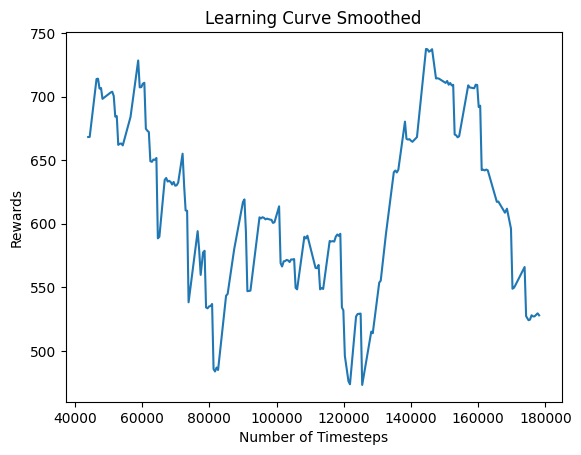

In [ ]:
### NOTE ####
### CHANGE THE CHECKPOINT FILE NAME STEPS TO 0 ###
### NOTE ####

# Basic Training Cycle
device="cuda" if torch.cuda.is_available() else "cpu"
my_agent = SubmittedAgent(file_path="checkpoints/experiment_1/rl_model_0_steps", device=device)
print(f"Training on device: {device}")

SAVE_CONFIG = {
    "save_freq": 20_000,
    "max_saved": 50,
    "save_path": "checkpoints",
}

# 2. Training setup
reward_functions = {
    'combo_reward': RewTerm(func=combo_reward, weight=0.5),
    'damage_reward': RewTerm(func=damage_reward, weight=0.3),
    'damage_penalty': RewTerm(func=damage_penalty, weight=3),
    'dodge_reward': RewTerm(func=dodge_reward, weight=4),
    'health_comparison': RewTerm(func=health_comparison, weight=1),
    'jump_reward': RewTerm(func=jump_reward, weight=1.5),
    'escape_reward': RewTerm(func=escape_reward, weight=1),
}
signal_subscriptions = {
    "on_win": ("win_signal", RewTerm(func=on_win_reward, weight=0.6)),
    "on_knockout": ("knockout_signal",RewTerm(func=knockout_reward, weight=0.7)),
}
reward_manager = RewardManager(reward_functions, signal_subscriptions)

selfplay_classes = [SelfPlayLatest, SelfPlayDynamic, SelfPlayRandom]
weights = [3, 1, 1]  # 3:1:1 ratio
selected_class = random.choices(selfplay_classes, weights=weights, k=1)[0]
selfplay_handler = selected_class(partial(SubmittedAgent))

opponents = {
    "self_play": (0.5, selfplay_handler),
    "based_agent": (0.05, partial(BasedAgent)),
    "random_agent": (0.05, partial(RandomAgent)),
    "sb3_agent1": (0.15, partial(SB3Agent, file_path="checkpoints/sb3_1/rl_model_10850567_steps")),
    "adibs_good_agent": (0.05, partial(AdibsAgent, file_path="checkpoints/adibs_model/rl_model_7605929_steps_good3")),
    "jumping_agent": (0.4, partial(SubmittedAgent, file_path="checkpoints/experiment_1_0/rl_model_2558357_steps_jumperer")),
}
opponent_cfg = OpponentsCfg(opponents=opponents)

save_handler = SaveHandler(
    agent=my_agent,
    run_name='experiment_1',
    mode=SaveHandlerMode.RESUME,
    **SAVE_CONFIG,
)

train(my_agent,
    reward_manager,
    save_handler,
    opponent_cfg,
    CameraResolution.LOW,
    train_timesteps=1_000_000,
    train_logging=TrainLogging.PLOT,
)


In [ ]:
# Other Model
device="cuda" if torch.cuda.is_available() else "cpu"
my_agent = SubmittedAgent(file_path="checkpoints/experiment_1/rl_model_0_steps", device=device)
print(f"Training on device: {device}")

SAVE_CONFIG = {
    "save_freq": 30_000,
    "max_saved": 7,
    "save_path": "checkpoints",
}

# 2. Training setup
reward_functions = {
    'health_comparison': RewTerm(func=health_comparison, weight=1),
    'dodge_reward': RewTerm(func=dodge_reward, weight=3.5),
    'dodge_buggy': RewTerm(func=dodge_buggy, weight=3.5),
    'cute_reward': RewTerm(func=cute_reward, weight=1),
    'damage_reward': RewTerm(func=damage_reward, weight=1),
    'damage_penalty': RewTerm(func=damage_penalty, weight=2),
    'movement_reward': RewTerm(func=movement_reward, weight=1)
}
signal_subscriptions = {
    "on_win": ("win_signal", RewTerm(func=on_win_reward, weight=1)),
    "on_knockout": ("knockout_signal",RewTerm(func=knockout_reward, weight=1)),
}
reward_manager = RewardManager(reward_functions, signal_subscriptions)

selfplay_classes = [SelfPlayLatest, SelfPlayDynamic, SelfPlayRandom]
weights = [3, 1, 1]  # 3:1:1 ratio
selected_class = random.choices(selfplay_classes, weights=weights, k=1)[0]
selfplay_handler = selected_class(partial(SubmittedAgent))

opponents = {
    "self_play": (0.2, selfplay_handler),
    "based_agent": (0.1, partial(BasedAgent)),
    "adibs_good_agent": (0.2, partial(AdibsAgent, file_path="checkpoints/adibs_model/rl_model_7605929_steps_good3")),
    "cutie": (0.3, partial(SubmittedAgent, file_path="checkpoints/experiment_1_0/rl_model_71085114_steps_agressive")),
    "jumper": (0.1, partial(SubmittedAgent, file_path="checkpoints/experiment_1_0/rl_model_1503561_steps_jumping")),
    "sb3": (0.1, partial(SB3Agent, file_path="checkpoints/sb3_1/rl_model_10850567_steps"))
}
opponent_cfg = OpponentsCfg(opponents=opponents)

save_handler = SaveHandler(
    agent=my_agent,
    run_name='experiment_1',
    mode=SaveHandlerMode.RESUME,
    **SAVE_CONFIG,
)

train(my_agent,
    reward_manager,
    save_handler,
    opponent_cfg,
    CameraResolution.LOW,
    train_timesteps=2_000_000,
    train_logging=TrainLogging.PLOT,
)


# Evaluation / Inference

Test your agents here!

In [87]:
# --- AGENT 1 ---
agent1 = "experiment_1/rl_model_282461_steps"
agent1 = SubmittedAgent(file_path=f"checkpoints/{agent1}")

# agent1 = "adibs_model/rl_model_2870138_steps_good2"
# agent1 = AdibsAgent(file_path=f"checkpoints/{agent1}")

# --- AGENT 2 ---
# agent2 = "adibs_model/rl_model_7605929_steps_good3"
# agent2 = SubmittedAgent(file_path=f"checkpoints/{agent2}")

agent2 = "experiment_1_0/rl_model_81688323_steps_cracked"
agent2 = SubmittedAgent(file_path=f"checkpoints/{agent2}")
# 
# agent2 = "experiment_1_0/rl_model_2558357_steps_jumperer"
# agent2 = SubmittedAgent(file_path=f"checkpoints/{agent2}")

# agent2 = "adibs_model/rl_model_7605929_steps_good3"
# agent2 = AdibsAgent(file_path=f"checkpoints/{agent2}")

# agent2 = "sb3_1/rl_model_10850567_steps"
# agent2 = SB3Agent(file_path=f"checkpoints/{agent2}")

# agent2 = RandomAgent()

# agent2 = UserInputAgent()

# agent2 = BasedAgent()

# agent2 = "losmodel/rl_model_1004400_steps"
# agent2 = RecurrentPPOAgent(file_path=f"checkpoints/{agent2}")

match_time = 90

run_match(
    agent_1=agent1,
    agent_2=agent2,
    agent_1_name='Cutie :3',
    agent_2_name='Cutie ^.^',
    video_path="cutie_v_cutie.mp4",
    resolution=CameraResolution.LOW,
    reward_manager=reward_manager,
    max_timesteps=30 * match_time,
)
os.system("start C:/Users/klamb/OneDrive/Documents/PythonCode/POETS/cutie_v_cutie.mp4")

# run_match(
#     agent_1=agent1,
#     agent_2=agent2,
#     agent_1_name='Cutie :3',
#     video_path="cutie_v_adibs.mp4",
#     agent_2_name='Adibs',
#     resolution=CameraResolution.LOW,
#     reward_manager=reward_manager,
#     max_timesteps=30 * match_time,
# )
# os.system("start C:/Users/klamb/OneDrive/Documents/PythonCode/POETS/cutie_v_adibs.mp4")



Obs space [-1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [1, 1, 1, 1, 1, 1, 1, 2, 12, 1, 1, 1, 1, 3, 11, 1, 1, 1, 1, 1, 1, 1, 2, 12, 1, 1, 1, 1, 3, 11]
Action space [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
video_path=cutie_v_cutie.mp4 -> Rendering


100%|█████████▉| 2699/2700 [00:51<00:00, 52.00it/s]


0